**CHALLENGE #1 - PIRATE PAIN CLASSIFICATION** 🏴



In [118]:
#Google drive mount
from google.colab import drive
drive.mount('/content/drive')
current_dir = "/content/drive/My Drive/1st Challenge/"
%cd $current_dir

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/1st Challenge


Libraries import

In [119]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict
import torch.nn.functional as F
from sklearn.metrics import f1_score
import torch.nn.functional as F

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

import builtins
max = builtins.max
min = builtins.min
print("Funzioni built-in 'max' e 'min' ripristinate.")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.8.0+cu126
Device: cuda
Funzioni built-in 'max' e 'min' ripristinate.


Let's load the data

In [120]:
X_train = pd.read_csv('pirate_pain_train.csv')
y_train = pd.read_csv('pirate_pain_train_labels.csv')
X_test = pd.read_csv('pirate_pain_test.csv')

Data Exploration

In [121]:
missing_values_train = X_train.isnull().sum()
if missing_values_train.sum() == 0:
  print("No missing values in X_train.")

missing_values_test = X_test.isnull().sum()
if missing_values_test.sum() == 0:
  print("No missing values in X_test.")

missing_values_y_train = y_train.isnull().sum()
if missing_values_y_train.sum() == 0:
  print("No missing values in y_train.")


print(f"The shape of X_train is: {X_train.shape}")

X_train.head(10)

No missing values in X_train.
No missing values in X_test.
No missing values in y_train.
The shape of X_train is: (105760, 40)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,3.999558e-06,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765107e-07,6.019627e-06,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,1.446051e-06,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2,2,2,2,two,two,two,0.938017,...,1.006865e-05,5.511079e-07,1.847597e-06,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2,2,2,2,two,two,two,1.090185,...,4.437266e-06,1.735459e-07,1.552722e-06,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5
5,0,5,2,0,2,1,two,two,two,1.146031,...,1.073167e-06,1.753837e-07,2.957340e-07,6.217311e-08,0.000007,0.006150,0.006444,0.033101,0.023767,0.5
6,0,6,2,1,2,1,two,two,two,1.025870,...,1.074800e-06,1.772156e-07,1.976558e-06,1.576086e-06,0.000005,0.006495,0.006421,0.031804,0.019056,0.5
7,0,7,2,2,2,2,two,two,two,1.038597,...,8.829074e-07,1.790415e-07,2.210562e-06,1.485741e-06,0.000000,0.015998,0.005397,0.035552,0.015732,0.5
8,0,8,2,2,0,1,two,two,two,0.984251,...,1.621055e-06,1.165161e-06,3.030164e-07,5.416678e-07,0.000000,0.020539,0.008517,0.008635,0.015257,0.5
9,0,9,0,2,2,2,two,two,two,1.054999,...,1.609114e-06,3.959558e-06,2.017157e-06,1.154349e-06,0.000007,0.007682,0.021383,0.034006,0.028966,0.5


In [122]:
# Check for duplicates
if X_train.duplicated().any():
    print("Duplicate rows found in X_train.")
else:
    print("No duplicate rows found in X_train.")

# Check for duplicates
if X_test.duplicated().any():
    print("Duplicate rows found in X_test.")
else:
    print("No duplicate rows found in X_test.")

No duplicate rows found in X_train.
No duplicate rows found in X_test.


In [123]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  object 
 7   n_hands        105760 non-null  object 
 8   n_eyes         105760 non-null  object 
 9   joint_00       105760 non-null  float64
 10  joint_01       105760 non-null  float64
 11  joint_02       105760 non-null  float64
 12  joint_03       105760 non-null  float64
 13  joint_04       105760 non-null  float64
 14  joint_05       105760 non-null  float64
 15  joint_06       105760 non-null  float64
 16  joint_07       105760 non-null  float64
 17  joint_08       105760 non-nul

We could have to think about whether or not to reduce the memory occupation of the columns of the dataset from float64 to float32.

But since in our case we have to operate with NNs that in torch are optimized to work with float32 variables it would be usless to keep them to float64.

In [124]:
#Let's check for the unique values of the relevant columns
print('Let\'s check for unique values of the X_train dataset')
print(X_train['n_eyes'].unique())
print(X_train['n_hands'].unique())
print(X_train['n_legs'].unique())

print(X_train['pain_survey_1'].unique())
print(X_train['pain_survey_2'].unique())
print(X_train['pain_survey_3'].unique())
print(X_train['pain_survey_4'].unique())

Let's check for unique values of the X_train dataset
['two' 'one+eye_patch']
['two' 'one+hook_hand']
['two' 'one+peg_leg']
[2 0 1]
[0 2 1]
[2 0 1]
[1 2 0]


We will begin by transforming the categorical variables into numerical ones, later we will provide embedding for them.

In [125]:
# Now we use embeddings for categorical features, so we convert their string labels to numerical ones.
# Let's replace nominal values with numerical ones
n_limbs = {
    'two': 2,
    'one+eye_patch': 1,
    'one+hook_hand': 1,
    'one+peg_leg': 1
}

X_train = X_train.replace({'n_eyes': n_limbs, 'n_hands': n_limbs, 'n_legs': n_limbs})
X_test = X_test.replace({'n_eyes': n_limbs, 'n_hands': n_limbs, 'n_legs': n_limbs})

# Ensure these columns are of integer type, as nn.Embedding expects LongTensor indices
X_train['n_eyes'] = X_train['n_eyes'].astype(int)
X_train['n_hands'] = X_train['n_hands'].astype(int)
X_train['n_legs'] = X_train['n_legs'].astype(int)

X_test['n_eyes'] = X_test['n_eyes'].astype(int)
X_test['n_hands'] = X_test['n_hands'].astype(int)
X_test['n_legs'] = X_test['n_legs'].astype(int)

# Also ensure pain_survey columns are int type for embeddings
pain_survey_cols = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
X_train[pain_survey_cols] = X_train[pain_survey_cols].astype(int)
X_test[pain_survey_cols] = X_test[pain_survey_cols].astype(int)

# Confirm the data types after conversion
print("X_train n_limb columns dtypes after conversion:")
print(X_train[['n_legs', 'n_hands', 'n_eyes']].dtypes)
print("X_train pain_survey columns dtypes after conversion:")
print(X_train[pain_survey_cols].dtypes)


X_train n_limb columns dtypes after conversion:
n_legs     int64
n_hands    int64
n_eyes     int64
dtype: object
X_train pain_survey columns dtypes after conversion:
pain_survey_1    int64
pain_survey_2    int64
pain_survey_3    int64
pain_survey_4    int64
dtype: object


In [126]:
#Let's start now by processing the data for the embeddings
pain_survey_cols = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
limb_cols = ['n_legs', 'n_hands', 'n_eyes']
joint_cols = [col for col in X_train.columns if col.startswith('joint_')]

# Convert the numerical features to float32 for better processing
X_train[joint_cols] = X_train[joint_cols].astype('float32')
X_test[joint_cols] = X_test[joint_cols].astype('float32') # Apply to X_test as well

# Combine all columns that need scaling
scale_columns = joint_cols

# Identify columns that should not be scaled for embeddings
embedding_cols = pain_survey_cols + limb_cols

print(embedding_cols)


['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes']


In [127]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  int64  
 7   n_hands        105760 non-null  int64  
 8   n_eyes         105760 non-null  int64  
 9   joint_00       105760 non-null  float32
 10  joint_01       105760 non-null  float32
 11  joint_02       105760 non-null  float32
 12  joint_03       105760 non-null  float32
 13  joint_04       105760 non-null  float32
 14  joint_05       105760 non-null  float32
 15  joint_06       105760 non-null  float32
 16  joint_07       105760 non-null  float32
 17  joint_08       105760 non-nul

In [128]:
X_train.describe()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
count,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,...,1.057600e+05,1.057600e+05,1.057600e+05,1.057600e+05,1.057600e+05,105760.000000,105760.000000,105760.000000,105760.000000,105760.0
mean,330.000000,79.500000,1.633746,1.654851,1.653640,1.663134,1.990923,1.990923,1.990923,0.943095,...,3.972126e-05,4.176794e-05,3.561780e-05,3.138109e-05,1.024604e-04,0.041905,0.058244,0.049886,0.062273,0.5
std,190.814948,46.187338,0.682423,0.669639,0.666649,0.661994,0.094841,0.094841,0.094841,0.202049,...,4.974359e-03,5.472111e-03,1.235068e-03,4.063172e-04,3.205551e-03,0.060292,0.079820,0.060773,0.072597,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000e+00,1.510494e-07,0.000000e+00,1.063144e-08,0.000000e+00,0.000203,0.000000,0.000000,0.000000,0.5
25%,165.000000,39.750000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.828277,...,6.545878e-08,3.321650e-07,3.275038e-07,2.841805e-07,7.161332e-07,0.009885,0.012652,0.016290,0.019638,0.5
50%,330.000000,79.500000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.005126,...,8.302747e-07,1.095971e-06,1.024209e-06,8.746148e-07,3.126723e-06,0.021898,0.031739,0.031843,0.039041,0.5
75%,495.000000,119.250000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.081039,...,2.800090e-06,3.079464e-06,3.021830e-06,2.507548e-06,9.946107e-06,0.048579,0.071051,0.058741,0.079518,0.5
max,660.000000,159.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.407968,...,1.442198e+00,1.305001e+00,2.742411e-01,3.643074e-02,9.473540e-01,1.223617,1.187419,1.412037,1.370765,0.5


Let's see now the targets

In [129]:
y_train.head()

,sample_index,label
0,0,no_pain
1,1,no_pain
2,2,low_pain
3,3,no_pain
4,4,no_pain


In [130]:
y_train.shape

(661, 2)

Let's transform the output labels into numerical values so that we can later exploit them.


In [131]:
target_classes = {
    'no_pain' : 0,
    'low_pain' : 1,
    'high_pain' : 2
}

#Let's change the target dataset
y_train = y_train.replace({'label': target_classes})

#Check if there is any null value
if y_train.isnull().values.any():
    print("There are null values in y_train.")
else:
    print("There are no null values in y_train.")

y_train.head()

There are no null values in y_train.


,sample_index,label
0,0,0
1,1,0
2,2,1
3,3,0
4,4,0


In [132]:
#let's treat the time field, making it useful as a feature!
T = 160 #number of timestep for each

#sine and cosine trasformation
X_train['time_sin'] = np.sin(2 * np.pi * X_train['time'] / T)
X_test['time_sin'] = np.sin(2 * np.pi * X_test['time'] / T)
X_train['time_cos'] = np.cos(2 * np.pi * X_train['time'] / T)
X_test['time_cos'] = np.cos(2 * np.pi * X_test['time'] / T)

#cast to float
X_train['time_sin'] = X_train['time_sin'].astype('float32')
X_train['time_cos'] = X_train['time_cos'].astype('float32')
X_test['time_sin'] = X_test['time_sin'].astype('float32')
X_test['time_cos'] = X_test['time_cos'].astype('float32')

print(X_train[['time','time_sin','time_cos']].head(10))

   time  time_sin  time_cos
0     0  0.000000  1.000000
1     1  0.039260  0.999229
2     2  0.078459  0.996917
3     3  0.117537  0.993068
4     4  0.156434  0.987688
5     5  0.195090  0.980785
6     6  0.233445  0.972370
7     7  0.271440  0.962455
8     8  0.309017  0.951057
9     9  0.346117  0.938191


Let's keep a separate df called 'X_train_labeled' that also contain the respectives target labels for each of the samples.

In [133]:
X_train_labeled = pd.merge(X_train, y_train, on='sample_index')

In [134]:
X_train_labeled.head()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30,time_sin,time_cos,label
0,0,0,2,0,2,1,2,2,2,1.094705,...,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5,0.000000,1.000000,0
1,0,1,2,2,2,2,2,2,2,1.135183,...,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5,0.039260,0.999229,0
2,0,2,2,0,2,2,2,2,2,1.080745,...,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5,0.078459,0.996917,0
3,0,3,2,2,2,2,2,2,2,0.938017,...,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5,0.117537,0.993068,0
4,0,4,2,2,2,2,2,2,2,1.090185,...,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5,0.156434,0.987688,0


We want now to see how our data is distributed and visualize it in order to gain some insights on it.

In [135]:
# Counts for each target class
label_counts = y_train['label'].value_counts()
print('Value counts for \'label\' column:')
print(label_counts)

Value counts for 'label' column:
label
0    511
1     94
2     56
Name: count, dtype: int64


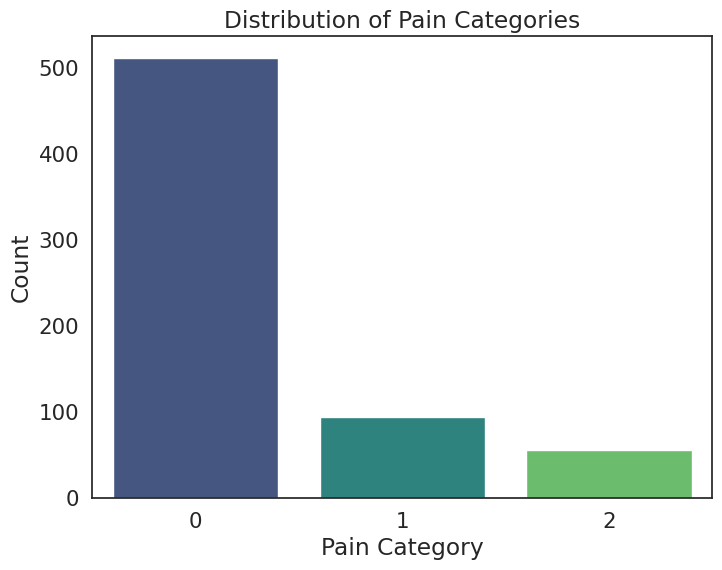

In [136]:
#Distribution of the labels
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=y_train, order=label_counts.index, palette='viridis')
plt.title('Distribution of Pain Categories')
plt.xlabel('Pain Category')
plt.ylabel('Count')
plt.show()

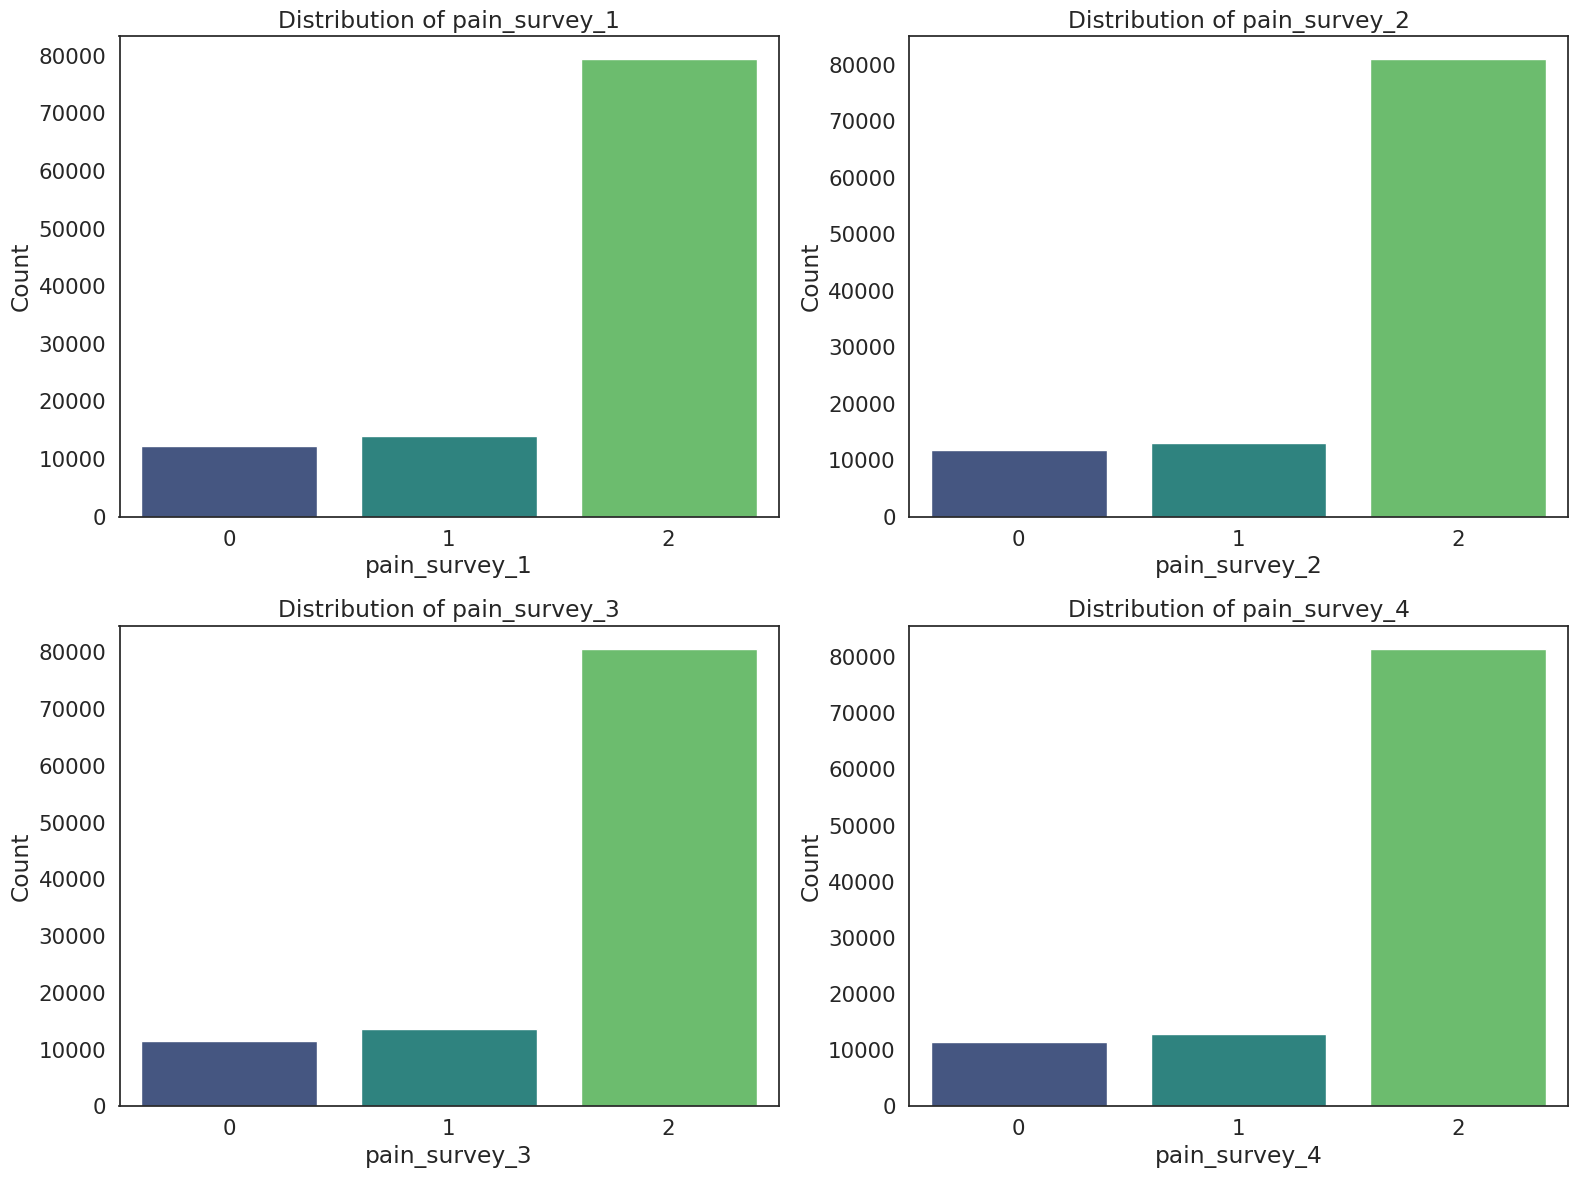

Count plots for pain survey features displayed.


In [137]:
#Pain survey distributions

pain_survey_cols = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']

plt.figure(figsize=(16, 12))
for i, col in enumerate(pain_survey_cols):
    plt.subplot(2, 2, i + 1)
    sns.countplot(x=col, data=X_train, palette='viridis')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()
print("Count plots for pain survey features displayed.")


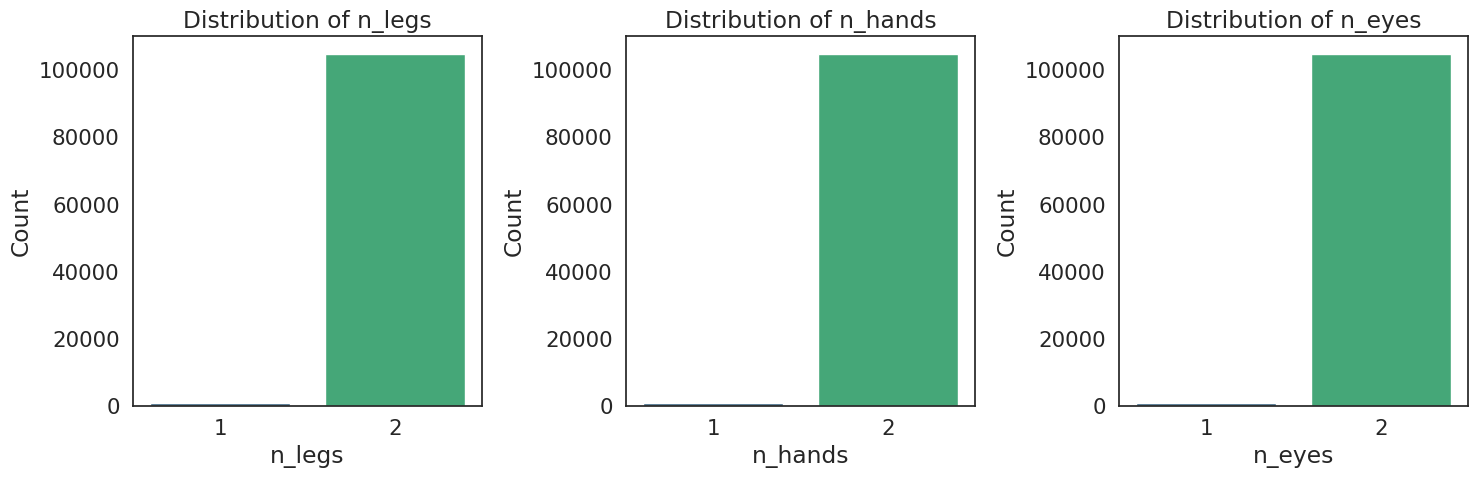

Count plots for number of limbs features displayed.


In [138]:
#limbs distributions

limbs_cols = ['n_legs', 'n_hands', 'n_eyes']

plt.figure(figsize=(15, 5))
for i, col in enumerate(limbs_cols):
    plt.subplot(1, 3, i + 1)
    sns.countplot(x=col, data=X_train, palette='viridis')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()
print("Count plots for number of limbs features displayed.")


In [139]:
#Just checking if the number of samples turn out to be okay and the timestamps are all the same for each pirate
n_users = len(X_train['sample_index'].unique())
print(n_users)

# Let's use a while loop to count rows per sample index
i = 0
cnt2 = 0
while i < len(X_train['sample_index'].unique()):
  count = len(X_train[X_train['sample_index'] == i])
  if count == 160:
    cnt2 += 1
  i += 1
print(f"Total number of users with 160 rows: {cnt2}")
print(f"Total number of users: {len(X_train['sample_index'].unique())}")

661
Total number of users with 160 rows: 661
Total number of users: 661


In [140]:
# Define a function to inspect sensor data for a specific joint for a specific user

def inspect_joint_data(user_id, joint_name):
    data = X_train[X_train['sample_index'] == user_id]
    joint_data = data[f'joint_{joint_name}']

    # Plot the sensor data for the user's joint, using 'time' for the x-axis
    fig, ax = plt.subplots(figsize=(17, 9))
    ax.plot(data['time'], joint_data)
    ax.set_title(f'Joint_{joint_name} Sensor Data for Sample Index {user_id}')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Sensor Value')
    # Ensure x-axis limits
    ax.set_xlim(-5, 165)
    plt.grid(True)
    plt.show()

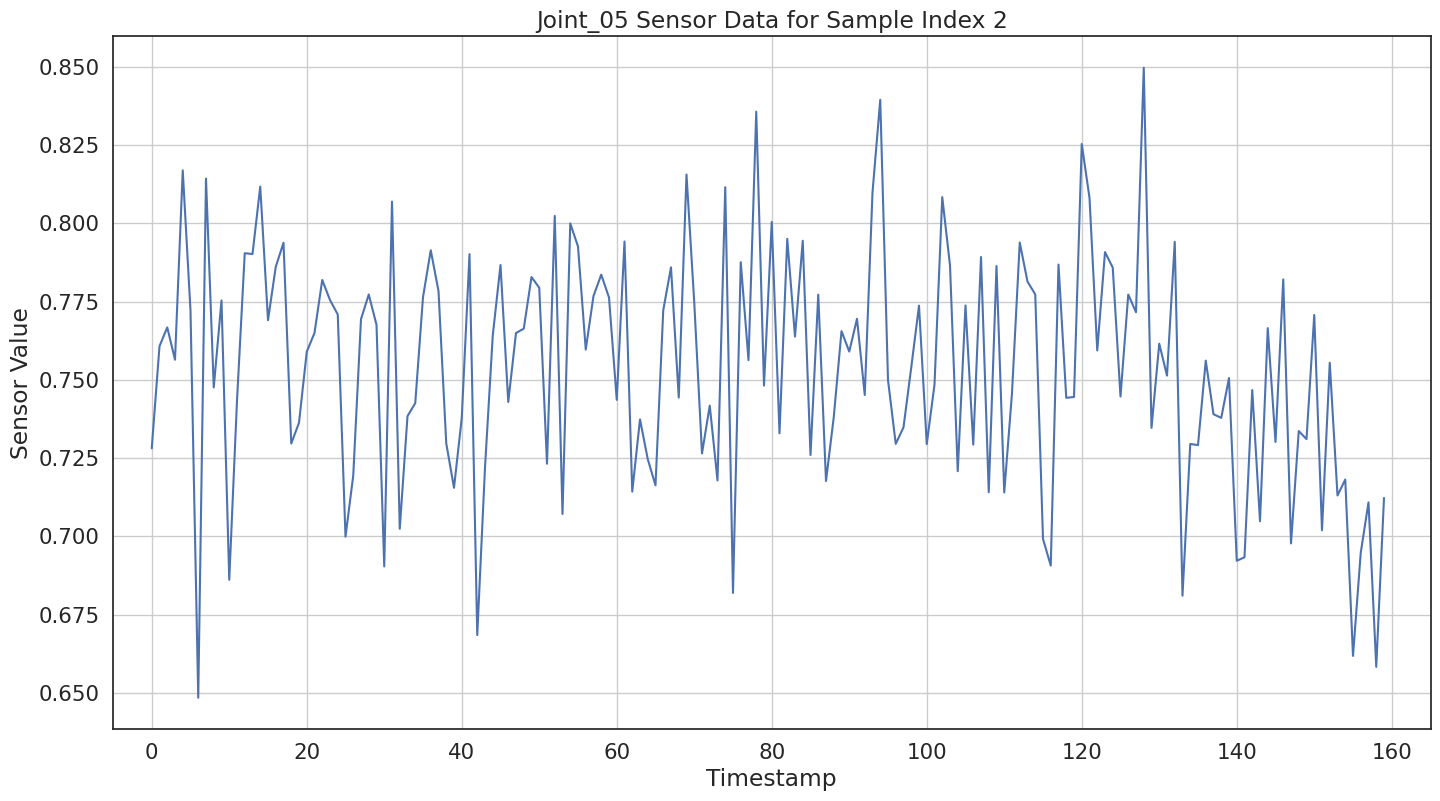

In [141]:
inspect_joint_data(2, '05')

# Task
Perform an exploratory data analysis to understand the relationships between pirate characteristics (limb count, pain survey responses, joint movements) and pain levels. Specifically, analyze the impact of limb count ('n_legs', 'n_hands', 'n_eyes') on pain categories and visualize the distribution of pain categories for each limb count. Additionally, explore pain survey response distributions ('pain_survey_1' to 'pain_survey_4') across different pain levels. Calculate and visualize the correlation matrix for all 'joint_' features. Finally, plot the average trajectories of a few representative 'joint_' features over 'time' for each pain category. Conclude with a summary of key findings and suggestions for future model building or feature engineering.

## Analyze Limb Count vs. Pain

### Subtask:
Investigate the relationship between the number of limbs ('n_legs', 'n_hands', 'n_eyes') and the pain labels ('y_train'). This involves grouping 'X_train' by 'sample_index' and merging with 'y_train' to see if pirates with fewer limbs tend to report higher pain levels. Visualize the distribution of pain categories for each limb count using aggregated bar plots to address your 'TODOOO' comment.



First, I need to prepare the data for analysis by merging X_train and y_train. Since the limb count columns ('n_legs', 'n_hands', 'n_eyes') are constant for each `sample_index` in `X_train`, I will group `X_train` by `sample_index` and take the first occurrence of these limb count features. Then, I will merge this aggregated DataFrame with `y_train` to create `df_merged` which contains `sample_index`, limb counts, and the corresponding pain label for each pirate.



In [142]:
# Ensure limb count columns are constant per sample_index
# This check is good practice, but based on prior observations, they should be constant.
for col in ['n_legs', 'n_hands', 'n_eyes']:
    if X_train.groupby('sample_index')[col].nunique().max() > 1:
        print(f"Warning: '{col}' is not constant across time for all samples. Proceeding with .first().")

# Extract relevant columns from X_train for each unique sample_index
# We take the 'first' value because 'n_legs', 'n_hands', 'n_eyes' are constant per sample_index.
unique_pirate_features = X_train.groupby('sample_index')[['n_legs', 'n_hands', 'n_eyes']].first().reset_index()

# Merge with y_train
df_merged = pd.merge(unique_pirate_features, y_train, on='sample_index', how='left')

print("First 5 rows of the merged DataFrame (df_merged):")
print(df_merged.head())
print("\nInformation about the merged DataFrame (df_merged):")
print(df_merged.info())

First 5 rows of the merged DataFrame (df_merged):
   sample_index  n_legs  n_hands  n_eyes  label
0             0       2        2       2      0
1             1       2        2       2      0
2             2       2        2       2      1
3             3       2        2       2      0
4             4       2        2       2      0

Information about the merged DataFrame (df_merged):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 661 entries, 0 to 660
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   sample_index  661 non-null    int64
 1   n_legs        661 non-null    int64
 2   n_hands       661 non-null    int64
 3   n_eyes        661 non-null    int64
 4   label         661 non-null    int64
dtypes: int64(5)
memory usage: 25.9 KB
None



Now that `df_merged` is available, I will create aggregated views for each limb column ('n_legs', 'n_hands', 'n_eyes') to show the distribution of pain categories for each limb count. This will prepare the data for plotting.



In [143]:
limb_cols = ['n_legs', 'n_hands', 'n_eyes']
pain_labels = {0: 'no_pain', 1: 'low_pain', 2: 'high_pain'}
df_merged['label_name'] = df_merged['label'].map(pain_labels)

# Create aggregated dataframes for plotting
aggregated_data = {}
for col in limb_cols:
    # Group by limb count and pain label, then count occurrences
    temp_df = df_merged.groupby([col, 'label_name']).size().unstack(fill_value=0)
    # Calculate percentage for better comparison
    temp_df = temp_df.div(temp_df.sum(axis=1), axis=0)
    aggregated_data[col] = temp_df

print("Aggregated data for n_legs:")
print(aggregated_data['n_legs'])
print("\nAggregated data for n_hands:")
print(aggregated_data['n_hands'])
print("\nAggregated data for n_eyes:")
print(aggregated_data['n_eyes'])

print('\n')
print(aggregated_data)


Aggregated data for n_legs:
label_name  high_pain  low_pain   no_pain
n_legs                                   
1            0.000000  0.166667  0.833333
2            0.085496  0.141985  0.772519

Aggregated data for n_hands:
label_name  high_pain  low_pain   no_pain
n_hands                                  
1            0.000000  0.166667  0.833333
2            0.085496  0.141985  0.772519

Aggregated data for n_eyes:
label_name  high_pain  low_pain   no_pain
n_eyes                                   
1            0.000000  0.166667  0.833333
2            0.085496  0.141985  0.772519


{'n_legs': label_name  high_pain  low_pain   no_pain
n_legs                                   
1            0.000000  0.166667  0.833333
2            0.085496  0.141985  0.772519, 'n_hands': label_name  high_pain  low_pain   no_pain
n_hands                                  
1            0.000000  0.166667  0.833333
2            0.085496  0.141985  0.772519, 'n_eyes': label_name  high_pain  low_pain   no_


I will now generate three separate bar plots, one for each limb count column (`n_legs`, `n_hands`, `n_eyes`), using the aggregated data to visualize the distribution of pain categories for each limb count. This will address the visualization requirement of the subtask.



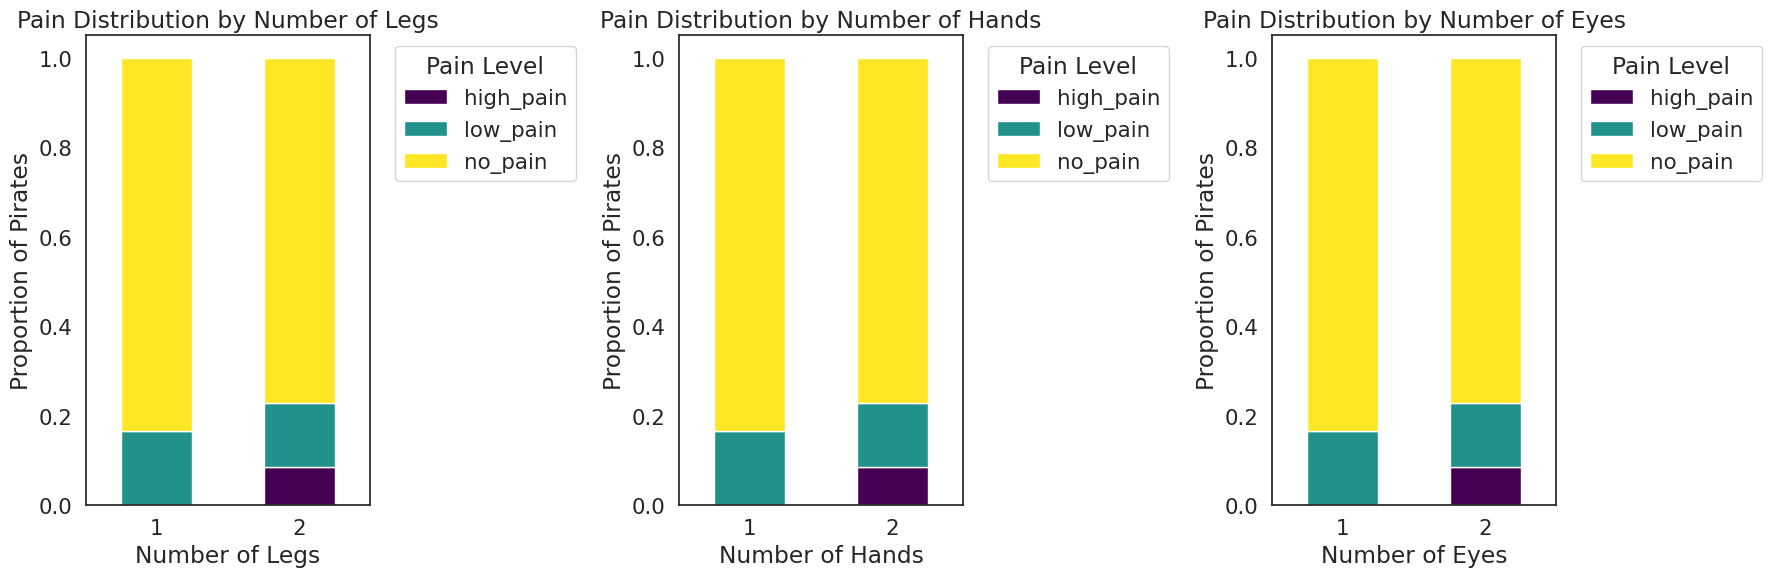

Bar plots showing pain distribution by limb count displayed.


In [144]:
plt.figure(figsize=(18, 6))

for i, col in enumerate(limb_cols):
    plt.subplot(1, 3, i + 1)
    # Plotting the aggregated data as stacked bar charts
    aggregated_data[col].plot(kind='bar', stacked=True, ax=plt.gca(), cmap='viridis')
    plt.title(f'Pain Distribution by Number of {col.replace("n_", "").capitalize()}')
    plt.xlabel(f'Number of {col.replace("n_", "").capitalize()}')
    plt.ylabel('Proportion of Pirates')
    plt.xticks(rotation=0)
    plt.legend(title='Pain Level', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
print("Bar plots showing pain distribution by limb count displayed.")


## Explore Pain Survey Responses per Pain Category

### Subtask:
Analyze the distribution of responses for 'pain_survey_1' to 'pain_survey_4' in 'X_train' for each pain category (no_pain, low_pain, high_pain) from 'y_train'. This can help determine if specific survey responses correlate with overall pain levels. Use aggregated bar charts or violin plots for visualization.



First, I need to prepare the data for analysis by merging X_train and y_train. Since y_train contains pain labels per sample_index, and X_train has time-series data for each sample_index, I will merge them based on 'sample_index' to associate each time point with its corresponding pain label. This will create a comprehensive DataFrame for further analysis.



In [145]:
df_pain_survey = pd.merge(X_train, y_train, on='sample_index', how='left')

pain_labels = {0: 'no_pain', 1: 'low_pain', 2: 'high_pain'}
df_pain_survey['label_name'] = df_pain_survey['label'].map(pain_labels)

print("First 5 rows of the merged DataFrame (df_pain_survey):")
print(df_pain_survey.head())
print("\nInformation about the merged DataFrame (df_pain_survey):")
print(df_pain_survey.info())


First 5 rows of the merged DataFrame (df_pain_survey):
   sample_index  time  pain_survey_1  pain_survey_2  pain_survey_3  \
0             0     0              2              0              2   
1             0     1              2              2              2   
2             0     2              2              0              2   
3             0     3              2              2              2   
4             0     4              2              2              2   

   pain_survey_4  n_legs  n_hands  n_eyes  joint_00  ...  joint_25  joint_26  \
0              1       2        2       2  1.094705  ...  0.000004  0.017592   
1              2       2        2       2  1.135183  ...  0.000000  0.013352   
2              2       2        2       2  1.080745  ...  0.000003  0.016225   
3              2       2        2       2  0.938017  ...  0.000000  0.011832   
4              2       2        2       2  1.090185  ...  0.000007  0.005360   

   joint_27  joint_28  joint_29  joint_30  


Now that the data is merged and the `label_name` is available, I will create count plots for each pain survey column (`pain_survey_1` to `pain_survey_4`), showing their distribution across different pain categories (no_pain, low_pain, high_pain). This directly addresses the visualization requirement of the subtask.



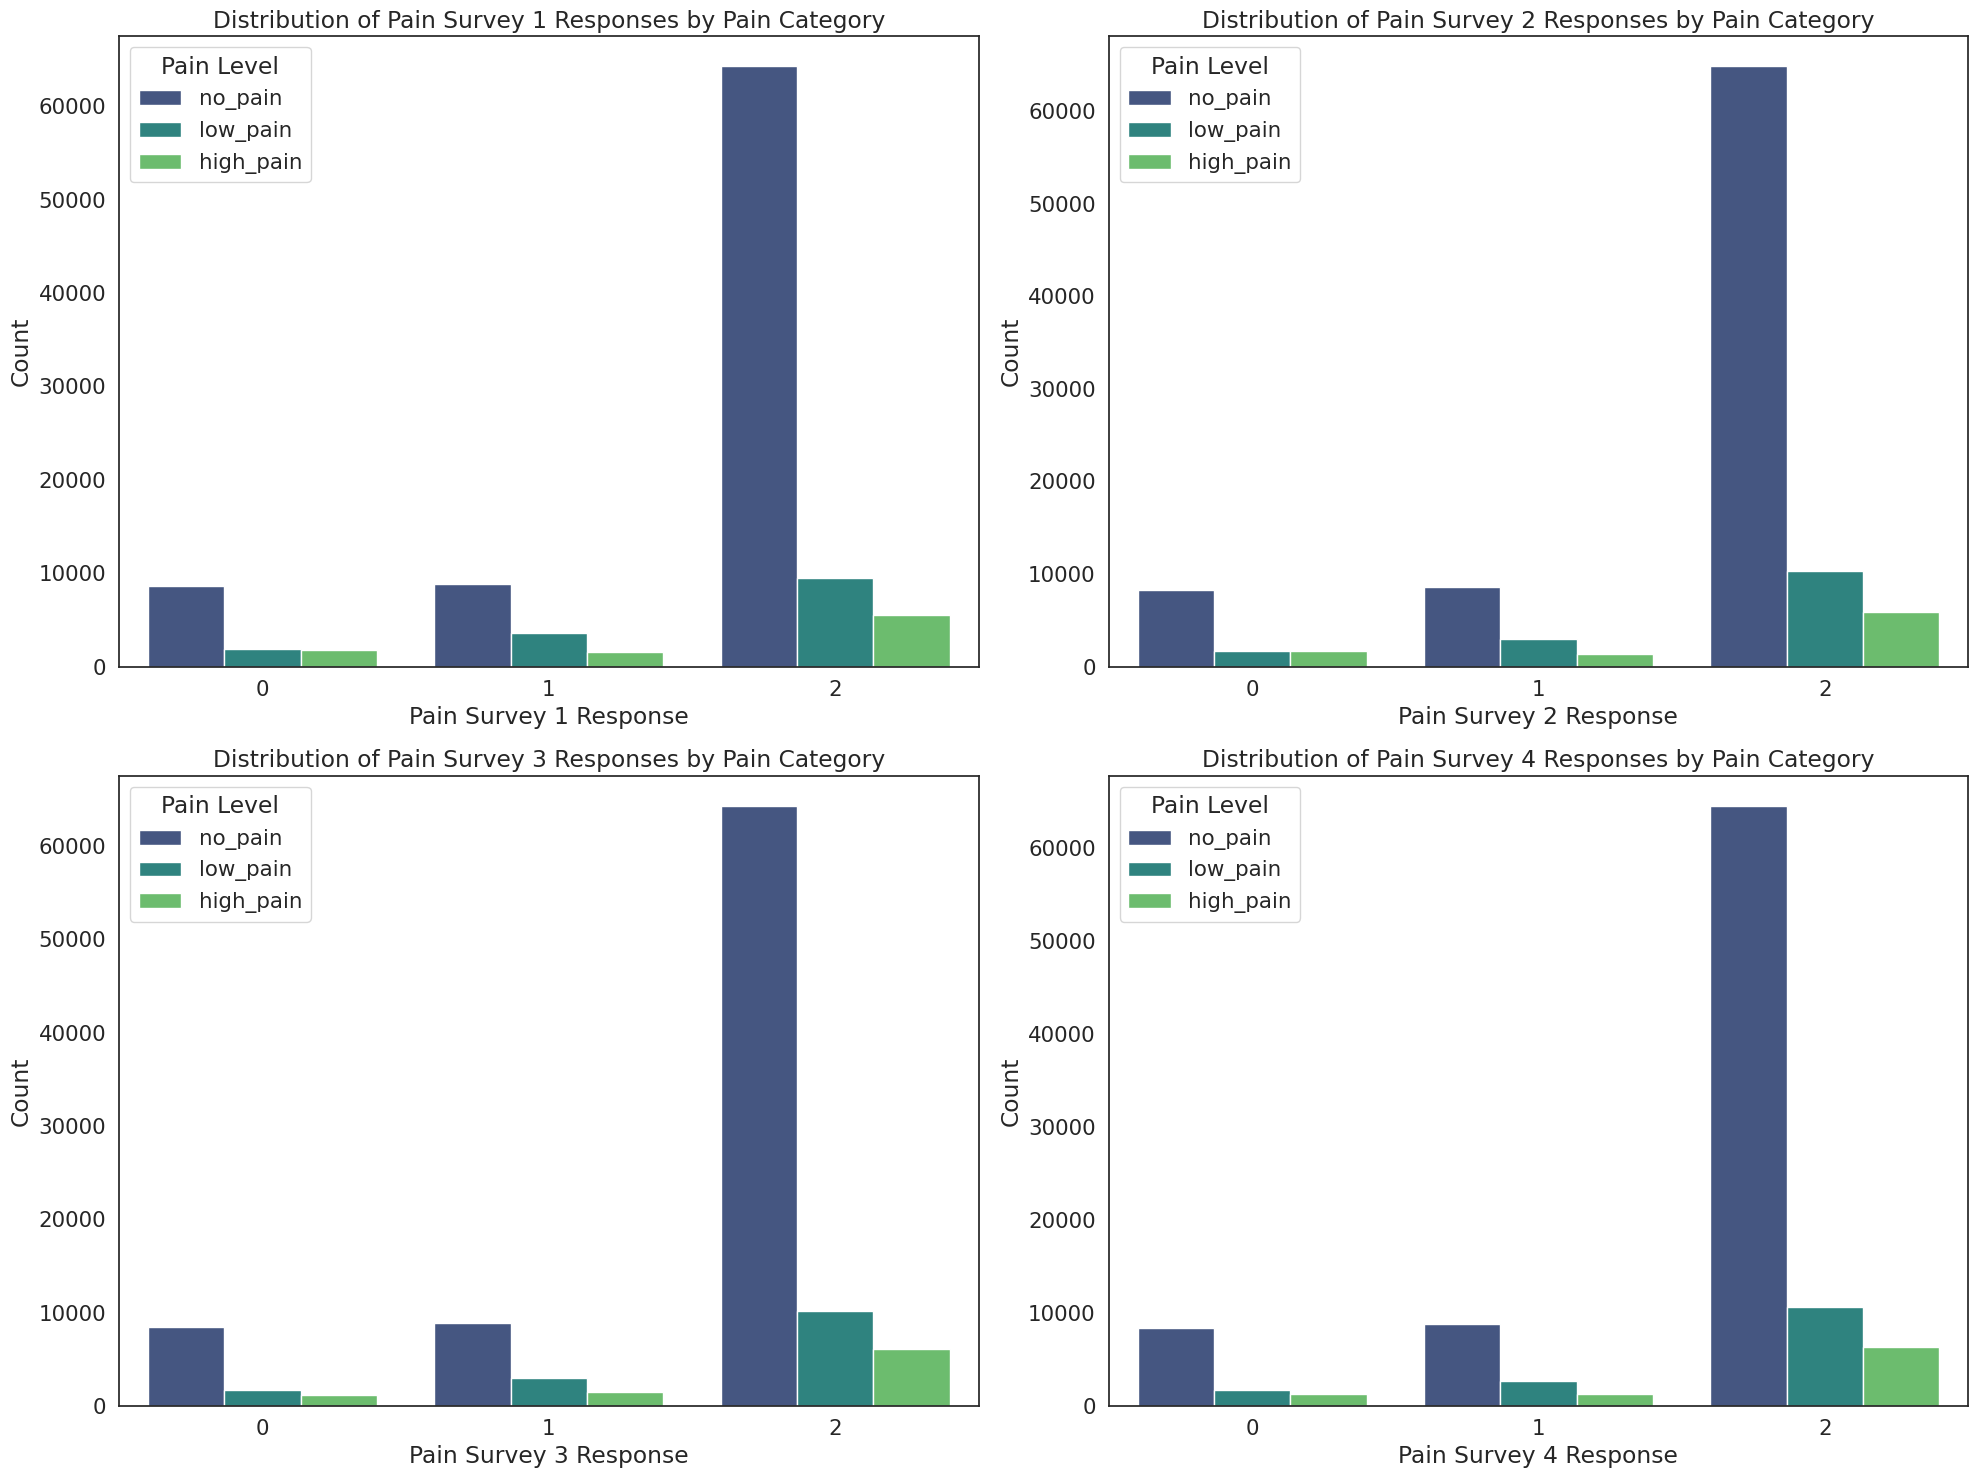

Count plots for pain survey responses by pain category displayed.


In [146]:
pain_survey_cols = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']

plt.figure(figsize=(20, 15))

for i, col in enumerate(pain_survey_cols):
    plt.subplot(2, 2, i + 1)
    sns.countplot(x=col, hue='label_name', data=df_pain_survey, palette='viridis', order=sorted(df_pain_survey[col].unique()))
    plt.title(f'Distribution of {col.replace("_", " ").title()} Responses by Pain Category')
    plt.xlabel(f'{col.replace("_", " ").title()} Response')
    plt.ylabel('Count')
    plt.legend(title='Pain Level')

plt.tight_layout()
plt.show()
print("Count plots for pain survey responses by pain category displayed.")



The next step in the overall task is to calculate and visualize the correlation matrix for all 'joint_' features. To achieve this, I first need to isolate the columns that start with 'joint_' from the `X_train` DataFrame.



In [147]:
joint_columns = [col for col in X_train.columns if col.startswith('joint_')]
df_joints = X_train[joint_columns]

print("First 5 rows of the DataFrame containing only joint features:")
print(df_joints.head())


First 5 rows of the DataFrame containing only joint features:
   joint_00  joint_01  joint_02  joint_03  joint_04  joint_05  joint_06  \
0  1.094705  0.985281  1.018302  1.010385  0.971717  1.022263  0.901755   
1  1.135183  1.021175  0.994343  1.052364  0.999944  1.012395  0.923341   
2  1.080745  0.962842  1.009588  0.977169  0.984740  1.019930  0.976567   
3  0.938017  1.081592  0.998021  0.987283  0.924161  1.002642  0.830982   
4  1.090185  1.032145  1.008710  0.963658  1.016291  1.031301  0.956008   

   joint_07  joint_08  joint_09  ...      joint_21      joint_22  joint_23  \
0  0.999659  0.712989  1.050142  ...  3.499558e-06  1.945042e-06  0.000004   
1  1.035850  0.722685  1.060313  ...  3.976952e-07  6.765108e-07  0.000006   
2  1.072751  0.668043  1.011410  ...  1.533820e-07  1.698525e-07  0.000001   
3  1.080755  0.702085  1.047223  ...  1.006865e-05  5.511079e-07  0.000002   
4  0.988023  0.712197  1.044731  ...  4.437265e-06  1.735459e-07  0.000002   

       joint_24  j


Now that I have isolated the 'joint_' features in `df_joints`, I need to calculate the correlation matrix for these features. This will show the pairwise correlation between all joint movements.



In [148]:
correlation_matrix = df_joints.corr()

print("First 5 rows and columns of the correlation matrix:")
print(correlation_matrix.iloc[:5, :5])


First 5 rows and columns of the correlation matrix:
          joint_00  joint_01  joint_02  joint_03  joint_04
joint_00  1.000000  0.764235  0.844885  0.706536  0.530988
joint_01  0.764235  1.000000  0.680542  0.817127  0.453518
joint_02  0.844885  0.680542  1.000000  0.834983  0.769236
joint_03  0.706536  0.817127  0.834983  1.000000  0.671963
joint_04  0.530988  0.453518  0.769236  0.671963  1.000000



Now that the correlation matrix has been calculated, I will visualize it using a heatmap to provide a clear graphical representation of the relationships between the 'joint_' features.



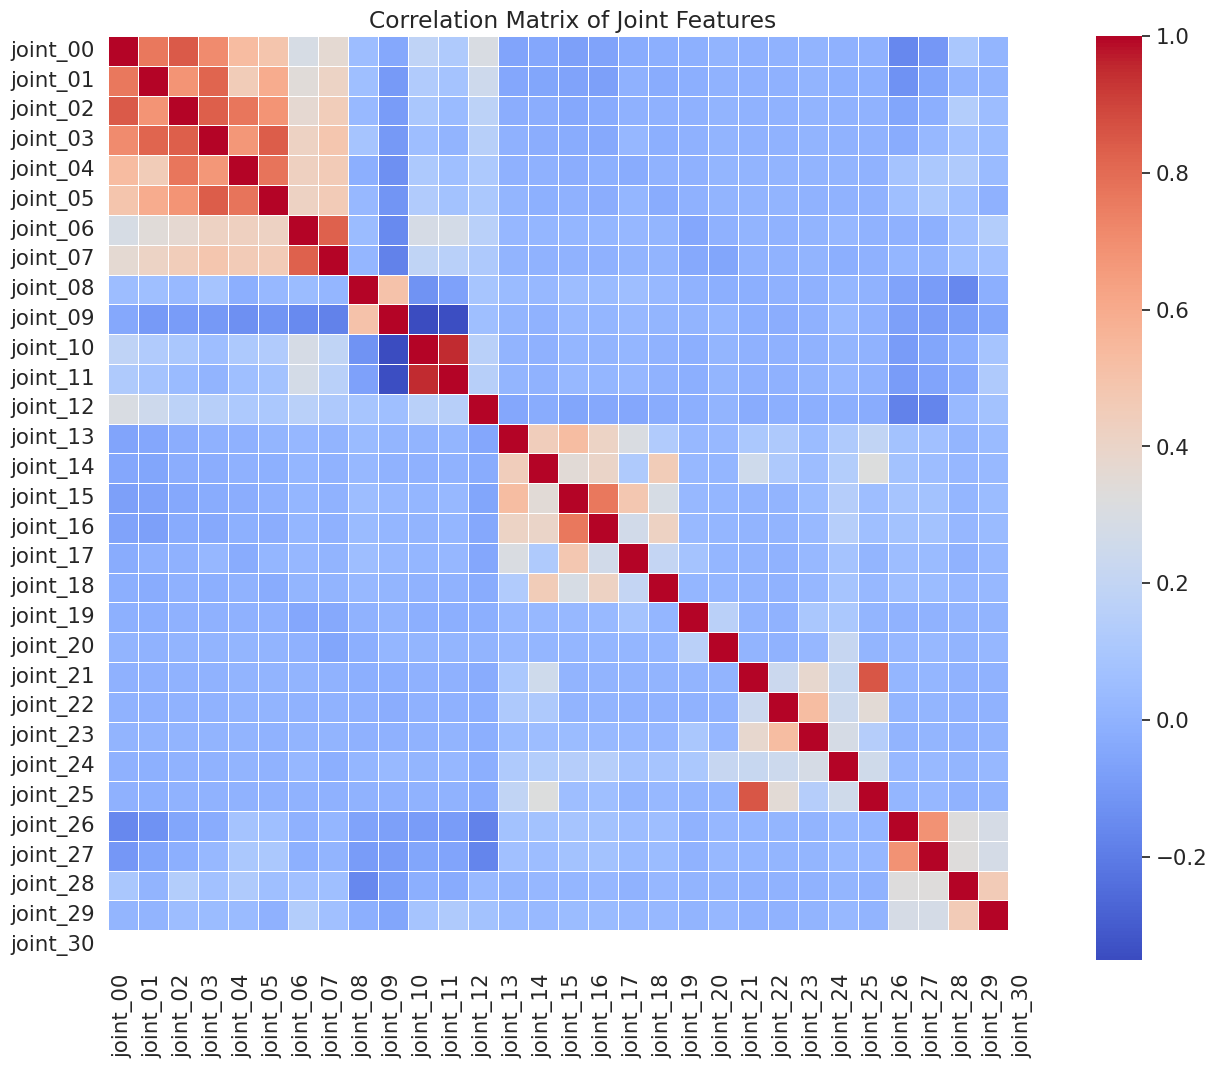

Correlation matrix heatmap of joint features displayed.


In [149]:
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Joint Features')
plt.show()
print("Correlation matrix heatmap of joint features displayed.")


In [150]:
'''#drop joint_10 because of high correlation with joint_11
X_train = X_train.drop(columns=['joint_10'])
X_train_labeled = X_train_labeled.drop(columns=['joint_10'])
X_test = X_test.drop(columns=['joint_10'])
joint_cols = [col for col in X_train_labeled.columns if col.startswith('joint_')]
scale_columns = joint_cols'''

In [151]:
X_train_labeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 42 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  int64  
 7   n_hands        105760 non-null  int64  
 8   n_eyes         105760 non-null  int64  
 9   joint_00       105760 non-null  float32
 10  joint_01       105760 non-null  float32
 11  joint_02       105760 non-null  float32
 12  joint_03       105760 non-null  float32
 13  joint_04       105760 non-null  float32
 14  joint_05       105760 non-null  float32
 15  joint_06       105760 non-null  float32
 16  joint_07       105760 non-null  float32
 17  joint_08       105760 non-nul

**Reasoning**:
I need to visualize the average trajectories of representative 'joint_' features over 'time' for each pain category. To achieve this, I will select a few 'joint_' columns, group the `df_pain_survey` DataFrame by 'time' and 'label_name', and then calculate the mean of these selected 'joint_' features. The resulting aggregated data will be used for plotting.



In [152]:
representative_joints = ['joint_00', 'joint_10', 'joint_20']

# Group by time and label_name, then calculate the mean for the representative joint features
joint_trajectories = df_pain_survey.groupby(['time', 'label_name'])[representative_joints].mean().reset_index()

print("First 5 rows of the joint trajectories data:")
print(joint_trajectories.head())


First 5 rows of the joint trajectories data:
   time label_name  joint_00  joint_10  joint_20
0     0  high_pain  0.931230  0.603773  0.000210
1     0   low_pain  0.894536  0.717914  0.000153
2     0    no_pain  0.953721  0.704355  0.000900
3     1  high_pain  0.935739  0.610130  0.000783
4     1   low_pain  0.908035  0.715326  0.000219


**Reasoning**:
Now that the average joint trajectories have been calculated, I will visualize them using line plots. This will allow us to observe how each selected joint feature changes over time for different pain categories, fulfilling the last part of the subtask.



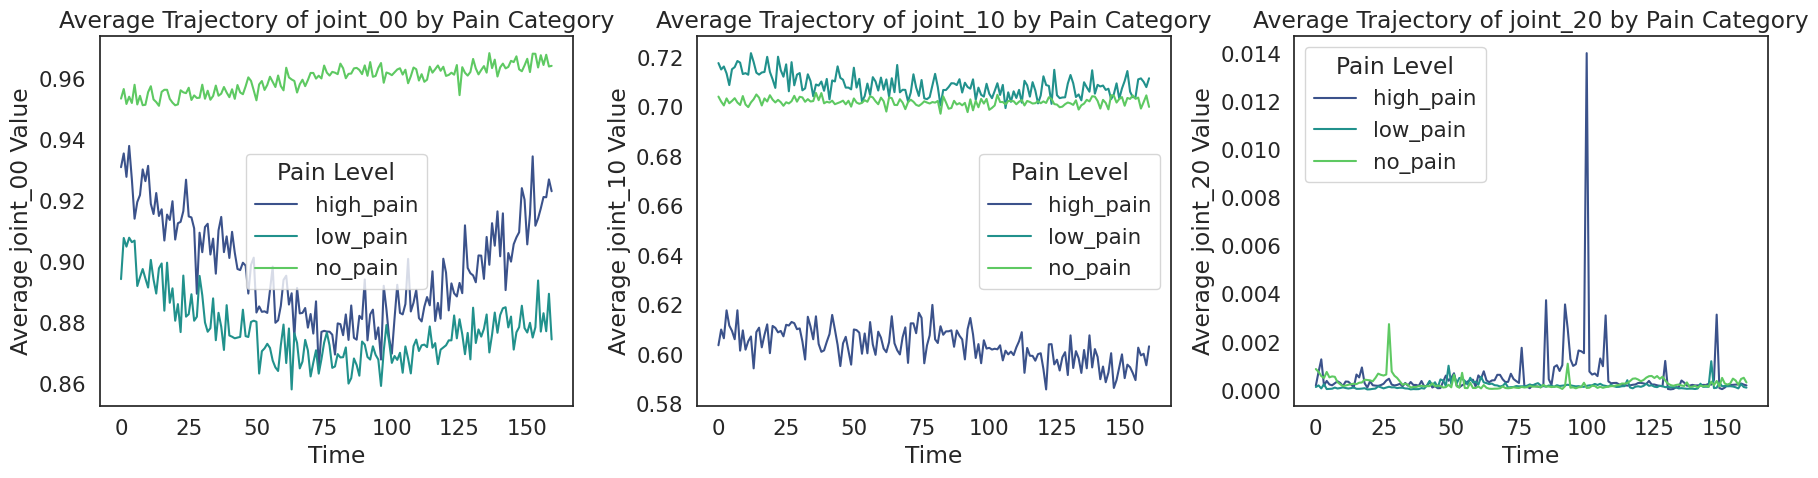

Line plots showing average joint trajectories over time for each pain category displayed.


In [153]:
plt.figure(figsize=(18, 5))

for i, joint in enumerate(representative_joints):
    plt.subplot(1, len(representative_joints), i + 1)
    sns.lineplot(data=joint_trajectories, x='time', y=joint, hue='label_name', palette='viridis')
    plt.title(f'Average Trajectory of {joint} by Pain Category')
    plt.xlabel('Time')
    plt.ylabel(f'Average {joint} Value')
    plt.legend(title='Pain Level')

plt.tight_layout()
plt.show()
print("Line plots showing average joint trajectories over time for each pain category displayed.")


In [154]:
#NB: THESE VALUES ARE JUST AN IDEA, WE SHOULD EMPLOY AUTOCORRELATION X WINDOWING TO FIND WHICH VALUES TO USE

# Define window size
WINDOW_SIZE = 160

# Define stride
STRIDE = 160

With a stride of 160 we can be sure that each different analysis is for each pirate since all of them are tracked from timestamp 0 to timestamp 160.

### Adjusting Data Preparation for Embeddings

Since we are now using embedding layers for 'n_limb' and 'pain_survey' features, these should not be min-max scaled. Instead, they should be passed as their original integer (or float, cast to long for embedding) values. We need to modify the `build_sequences` function to return three separate arrays: one for pain survey features, one for limb features, and one for the remaining numerical features.

### Adapting the Model for Embeddings

To implement the embedding strategy, we'll need to modify the `RecurrentClassifier` class. Specifically, we will:

1.  **Define Embedding Layers**: Create `nn.Embedding` layers for each categorical feature ('n_legs', 'n_hands', 'n_eyes', and 'pain_survey_1' through 'pain_survey_4'). Each embedding layer will map integer indices (representing the categories) to dense vectors.
2.  **Concatenate Embeddings with Numerical Features**: In the `forward` pass, the output of these embedding layers will be concatenated with the remaining numerical (joint) features before being fed into the recurrent neural network (RNN, GRU, or LSTM).
3.  **Adjust Input Size**: The `input_size` for the recurrent layer will need to be updated to account for the dimensions of the concatenated embeddings and scaled numerical features.

Let's now define a function get_sequences (spiega meglio).

In [155]:
def build_sequences_with_embeddings(df, window=160, stride=160):
    dataset_pain_survey = []
    dataset_limb = []
    dataset_numerical = []
    labels = []
    dataset_sample_index = []  #array to keep track of the user

    has_labels_col = 'label' in df.columns # Check if 'label' column exists in the input df

    # iterate users
    for uid in df['sample_index'].unique():
        user_df = df[df['sample_index'] == uid].sort_values('time')

        temp_pain_survey = user_df[pain_survey_cols].values
        temp_limb = user_df[limb_cols].values
        temp_numerical = user_df[scale_columns].values
        temp_time_features = user_df[['time_sin','time_cos']].values
        temp_numerical = np.concatenate([temp_numerical, temp_time_features], axis=1)

        current_user_label = None
        if has_labels_col:
            # label per user (assume unique)
            current_user_label = user_df['label'].iloc[0]

        T = temp_numerical.shape[0]
        if T == 0:
            continue

        # compute start indices for sliding windows
        starts = list(range(0, max(1, T - window + 1), stride))
        # ensure last frame is included
        if starts and starts[-1] + window < T:
            starts.append(max(0, T - window))
        elif not starts and T >= window: # If starts is empty but a window can fit
             starts.append(0)

        for s in starts:
            end = s + window
            ps_seg = temp_pain_survey[s:end]
            limb_seg = temp_limb[s:end]
            num_seg = temp_numerical[s:end]

            seg_len = num_seg.shape[0]
            if seg_len < window:
                pad_len = window - seg_len
                if seg_len == 0:
                    last_ps = temp_pain_survey[0:1]
                    last_limb = temp_limb[0:1]
                    last_num = temp_numerical[0:1]
                else:
                    last_ps = ps_seg[-1:].copy()
                    last_limb = limb_seg[-1:].copy()
                    last_num = num_seg[-1:].copy()

                pad_ps = np.repeat(last_ps, pad_len, axis=0)
                pad_limb = np.repeat(last_limb, pad_len, axis=0)
                pad_num = np.repeat(last_num, pad_len, axis=0)

                ps_seg = np.vstack([ps_seg, pad_ps])
                limb_seg = np.vstack([limb_seg, pad_limb])
                num_seg = np.vstack([num_seg, pad_num])

            # now segs are exactly length window
            dataset_pain_survey.append(ps_seg)
            dataset_limb.append(limb_seg)
            dataset_numerical.append(num_seg)
            if has_labels_col: # Only append label if the column exists in the input df
                labels.append(current_user_label)
            dataset_sample_index.append(uid)  # ✅ aggiunto: registra utente per ogni finestra

    # convert to numpy arrays
    dataset_pain_survey = np.array(dataset_pain_survey)
    dataset_limb = np.array(dataset_limb)
    dataset_numerical = np.array(dataset_numerical)
    labels = np.array(labels)
    dataset_sample_index = np.array(dataset_sample_index)  # ✅ convertilo anche lui

    # return also sample_index
    return dataset_pain_survey, dataset_limb, dataset_numerical, labels, dataset_sample_index

In [156]:
# Let's define the first batch size, we will then update it
BATCH_SIZE = 64

In [157]:
# Define the make_loader function
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [158]:
# Recurrent summary function -> prints a summary (the one form torch does not work here)
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [159]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()

        # W to transform hidden states
        self.W = nn.Linear(hidden_size, hidden_size, bias=False)
        # v context vector
        self.v = nn.Parameter(torch.rand(hidden_size))

    def forward(self, rnn_output):
        # rnn_output shape: (batch_size, seq_len, hidden_size)

        # 1. score computation: tanh(H @ W)
        u = torch.tanh(self.W(rnn_output))

        # 2. Application of context vector v
        v_expanded = self.v.repeat(rnn_output.size(0), 1).unsqueeze(1)
        # energy shape: (batch_size, seq_len)
        energy = torch.bmm(v_expanded, u.transpose(1, 2)).squeeze(1)

        # 3. Softmax normalization to obtain attention weights
        alpha = F.softmax(energy, dim=1)

        # 4. creation of weighted context vector
        # context shape: (batch_size, hidden_size)
        context = torch.bmm(alpha.unsqueeze(1), rnn_output).squeeze(1)

        return context, alpha

###MODEL BUILDING

In [160]:
class RecurrentClassifierWithEmbeddings(nn.Module):
    def __init__(
        self,
        num_numerical_features, # joint_xx features
        num_pain_survey_categories,  # num of unique categories in pain_survey features
        num_limb_categories, # num of unique categories in your n_limb features
        embedding_dim, # size of the dense vector
        hidden_size,
        num_layers,
        num_classes,
        rnn_type='GRU',
        bidirectional=False,
        dropout_rate=0.2
    ):
        super().__init__()

        self.rnn_type = rnn_type
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional


        # Embedding layers
        self.pain_survey_embeddings = nn.ModuleList([
            nn.Embedding(num_pain_survey_categories, embedding_dim) for _ in range(4)
        ])
        self.limb_embeddings = nn.ModuleList([
            nn.Embedding(num_limb_categories, embedding_dim) for _ in range(3)
        ])

        # Compute total dimension of the RNN input and of the RNN layers
        total_embedded_dim = (4 * embedding_dim) + (3 * embedding_dim)
        input_size_for_rnn = num_numerical_features + total_embedded_dim
        rnn_map = {
            'RNN': nn.RNN, 'GRU': nn.GRU, 'LSTM': nn.LSTM
        }
        rnn_module = rnn_map[rnn_type]
        dropout_val = dropout_rate if num_layers > 1 else 0
        self.rnn = rnn_module(
            input_size=input_size_for_rnn,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        num_directions = 2 if self.bidirectional else 1
        rnn_output_size = hidden_size * num_directions

        # initialize attention layer
        self.attention = Attention(rnn_output_size)

        # classifier now receive attention output
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            # input is the dimension of the context vector, which is equal to rnn_output_size
            nn.Linear(rnn_output_size, num_classes)
        )

    def forward(self, x_pain_survey, x_limb, x_numerical):
        # compute and concatenate embeddings
        embedded_pain_surveys = []
        for i in range(4):
            embedded_pain_surveys.append(self.pain_survey_embeddings[i](x_pain_survey[:, :, i].long()))
        embedded_pain_surveys = torch.cat(embedded_pain_surveys, dim=-1)

        embedded_limbs = []
        for i in range(3):
            embedded_limbs.append(self.limb_embeddings[i](x_limb[:, :, i].long()))
        embedded_limbs = torch.cat(embedded_limbs, dim=-1)

        combined_x = torch.cat((embedded_pain_surveys, embedded_limbs, x_numerical), dim=-1)

        # Forward pass RNN/GRU
        # rnn_out shape: (batch_size, seq_length, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(combined_x)

        # replace last state extraction with the attention
        context_vector, attention_weights = self.attention(rnn_out)

        # Classification: using context vector
        logits = self.classifier(context_vector)

        return logits

In [161]:
#HERE WE ARE WITH OUR NEW MODEL NOW ABLE TO SUPPORT EMBEDDINGS

X_tr_numerical = X_train.drop(columns=['sample_index', 'time', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes'])
input_shape = X_tr_numerical.shape[1:]
# (old )num_classes = len(np.unique(y_train))
num_classes = len(y_train['label'].unique()) # Corrected: Get unique values from the 'label' column only


print(f'Input shape of numerical features: {input_shape}')
print(f'Number of classes: {num_classes}')


# Define embedding specific parameters and some hyperparameters
EMBEDDING_DIM = 8 # Dimension of the embedding vectors
NUM_PAIN_SURVEY_CATEGORIES = 3 # Values are 0, 1, 2
NUM_LIMB_CATEGORIES = 3 # Values are 1, 2 (index 0 will be unused but needed for nn.Embedding size)
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 128        # Neurons per layer
DROPOUT_RATE = 0.4       # Dropout probability
LEARNING_RATE = 1e-4
L1_LAMBDA = 0
L2_LAMBDA = 1e-3
SMOOTHING = 0.02


# Number of numerical features (excluding pain_survey and limb features)
num_numerical_features = X_tr_numerical.shape[-1]

# Create model and display architecture with parameter count
rnn_model_emb = RecurrentClassifierWithEmbeddings(
    num_numerical_features=num_numerical_features,
    num_pain_survey_categories=NUM_PAIN_SURVEY_CATEGORIES,
    num_limb_categories=NUM_LIMB_CATEGORIES,
    embedding_dim=EMBEDDING_DIM,
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=False,
    rnn_type='GRU'
).to(device)

# Custom summary for the new model due to multiple inputs
print(rnn_model_emb)

# Set up TensorBoard logging and save model architecture
experiment_name = "gru_embeddings"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
# We can't use add_graph directly with multiple inputs in the same way, but can still log other things.
# For a detailed graph, one might need to wrap the model or manually trace.

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model_emb.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))


Input shape of numerical features: (32,)
Number of classes: 3
RecurrentClassifierWithEmbeddings(
  (pain_survey_embeddings): ModuleList(
    (0-3): 4 x Embedding(3, 8)
  )
  (limb_embeddings): ModuleList(
    (0-2): 3 x Embedding(3, 8)
  )
  (rnn): GRU(88, 128, num_layers=2, batch_first=True, dropout=0.4)
  (attention): Attention(
    (W): Linear(in_features=128, out_features=128, bias=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.4, inplace=False)
    (1): Linear(in_features=128, out_features=3, bias=True)
  )
)


Now we want to set up the loss function we will use. We will use a crossentropy loss function cosindering the problem we are facing.

Now, as we saw during our data exploration and analysis, our dataset is unbalanced towards the 'no pain' (0) label. So we want to address this by inserting this knowledge into the training.

So we will calculate the class weights, then update the loss criterin with the weights. This will penalize the model more for misclassifying 'low_pain' and 'high_pain'.

To address the class imbalance, I'll calculate inverse class weights from `y_tr`, initialize `nn.CrossEntropyLoss` with these weights, and then retrain the `rnn_model`. After retraining, I will summarize the impact of weighted loss on the model's performance, especially regarding minority classes.



In [162]:
#assess class imbalance:
#find weights: this helps the model pay more attention to the minority classes during training.
classes = np.unique(y_train['label'])
print(classes)
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train['label']
)
#applies an adjustment factor 'a' (set to 0.7) to these balanced weights, allowing the fine-tuninig of how aggressively the imbalance in the classes is corrected.
a = 0.7 #it's an hyperparameter that can be changed
cw = 1 + (weights - 1) * a

print(weights)
print(cw)

class_weights = torch.tensor(cw, dtype=torch.float32).to(device)
print(class_weights)

[0 1 2]
[0.43118069 2.34397163 3.93452381]
[0.60182648 1.94078014 3.05416667]
tensor([0.6018, 1.9408, 3.0542], device='cuda:0')


In [163]:
# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=SMOOTHING)  # with weight initialization and label_smoothing

## Training

In [164]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [165]:
# Modify train_one_epoch and validate_one_epoch to handle multiple inputs
def train_one_epoch_emb(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=L1_LAMBDA, l2_lambda=L2_LAMBDA, max_grad_norm=1.0):

    model.train()

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # iterate through training batches
    for batch_idx, (x_ps, x_l, x_num, targets) in enumerate(train_loader):
        #move data to cpu/gpu
        x_ps, x_l, x_num, targets = x_ps.to(device), x_l.to(device), x_num.to(device), targets.to(device)

        #clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        #forward pass
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(x_ps, x_l, x_num)
            loss = criterion(logits, targets)

            #l1,l2 normalization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm

        #Backward pass with gradient scaler
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        scaler.step(optimizer)
        scaler.update()

        # accumulate metrics
        running_loss += loss.item() * targets.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )
    return epoch_loss, epoch_f1


In [166]:
def validate_one_epoch_emb(model, val_loader, criterion, device):
    if val_loader is None:
        return 0.0, 0.0
    model.eval()
    running_loss = 0.0

    # container to accumulate prediction window by window for each pirate
    user_probs = defaultdict(list)
    user_targets = {}

    with torch.no_grad():
        for x_ps, x_l, x_num, targets, sample_idx in val_loader:
            x_ps, x_l, x_num, targets = (
                x_ps.to(device),
                x_l.to(device),
                x_num.to(device),
                targets.to(device),
            )

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == "cuda")):
                logits = model(x_ps, x_l, x_num)
                loss = criterion(logits, targets)

            running_loss += loss.item() * targets.size(0)

            # compute softmax probability
            probs = F.softmax(logits, dim=1).cpu().numpy()

            # accumulate prediction and target for each pirate
            for i, user_id in enumerate(sample_idx.cpu().numpy()):
                user_probs[user_id].append(probs[i])
                user_targets[user_id] = targets[i].cpu().item()  # unico label per utente

    # aggregate each pirate windows in a single prediction
    all_user_preds = []
    all_user_targets = []

    for user_id, probs_list in user_probs.items():
        mean_prob = np.mean(probs_list, axis=0)  # softmax mean
        pred_class = np.argmax(mean_prob)
        all_user_preds.append(pred_class)
        all_user_targets.append(user_targets[user_id])

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_f1 = f1_score(all_user_targets, all_user_preds, average="weighted")

    return epoch_loss, epoch_f1

In [167]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [168]:
def fit_emb(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=L1_LAMBDA, l2_lambda=L2_LAMBDA, max_grad_norm=1.0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    training_history = {'train_loss': [], 'val_loss': [], 'train_f1': [], 'val_f1': []}

    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    for epoch in range(1, epochs + 1):
        train_loss, train_f1 = train_one_epoch_emb(model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda, max_grad_norm)
        val_loss, val_f1 = validate_one_epoch_emb(model, val_loader, criterion, device)

        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        if writer is not None:
            log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model)

        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    if writer is not None:
        writer.close()

    return model, training_history

---

##*From here let's start with the creation and the training of the models*

---

---
# **EMBEDDINGS**
---

## **K-Shuffle-Split Cross Validation**

In [169]:
# Cross-validation
K = 5                   # Number of splits
N_VAL_USERS = 66        # Number of users for validation split

# Training
EPOCHS = 500            # Maximum epochs
PATIENCE = 35           # Early stopping patience
VERBOSE = 1             # Print frequency

# Optimisation
LEARNING_RATE = 1e-4    # Learning rate
BATCH_SIZE = 32         # Batch size
WINDOW_SIZE = 32        # Input window size (ideal value obtained through my colleague work)
STRIDE = 16             # Input stride

# Architecture
HIDDEN_LAYERS = 2       # Hidden layers
HIDDEN_SIZE = 128       # Neurons per layer
RNN_TYPE = 'GRU'        # Type of RNN architecture
BIDIRECTIONAL = False   # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0.4      # Dropout probability
L1_LAMBDA = 0           # L1 penalty
L2_LAMBDA = 1e-3        # L2 penalty
MAX_GRAD_NORM = 1.0     # For gradient clipping

# Label smoothing
SMOOTHING = 0.02

# Define embedding specific parameters
EMBEDDING_DIM = 8       # Dimension of the embedding vectors
NUM_PAIN_SURVEY_CATEGORIES = 3          # Values are 0, 1, 2
NUM_LIMB_CATEGORIES = 3 # Values are 1, 2 (index 0 will be unused but needed for nn.Embedding size)

# Training utilities
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=SMOOTHING)  # with weight initialization & label smoothing


In [170]:
def k_shuffle_split_cross_validation_round_rnn(df, epochs, criterion, device,
                                 k, n_val_users, batch_size, hidden_layers, hidden_size, learning_rate, dropout_rate,
                                 window_size, stride, rnn_type, bidirectional,
                                 l1_lambda=0, l2_lambda=0, max_grad_norm=1.0, patience=0, evaluation_metric="val_f1", mode='max',
                                 restore_best_weights=True, writer=None, verbose=10, seed=42, experiment_name=""):

    '''Perform K-fold shuffle split cross-validation with pirate-based splitting for time series data.
    Args:
        df: DataFrame df_train_labeled (we must pass here the one with labels)
        # ... (descrizione omessa per brevità)
    '''

    # Initialise containers for results
    fold_losses = {}
    fold_metrics = {}
    best_scores = {}

    ## Get model architecture parameters
    in_features = df.shape[1] - 2
    #we have removed 'sample_index','time' and 'label'columns
    print(in_features)
    # Assuming 'label' column is directly in df or mapped from 'activity' in comments
    # If 'activity' is meant to be the label column, it needs to be mapped or handled.
    # For now, using 'label' as it's present in X_train_labeled.
    num_classes = len(df['label'].unique())
    print(num_classes)

    #initialize model
    rnn_model_emb = RecurrentClassifierWithEmbeddings(
        num_numerical_features=num_numerical_features,
        num_pain_survey_categories=NUM_PAIN_SURVEY_CATEGORIES,
        num_limb_categories=NUM_LIMB_CATEGORIES,
        embedding_dim=EMBEDDING_DIM,
        hidden_size=HIDDEN_SIZE,
        num_layers=HIDDEN_LAYERS,
        num_classes=num_classes,
        dropout_rate=DROPOUT_RATE,
        bidirectional=bidirectional,
        rnn_type='GRU'
    ).to(device)


    # Store initial weights to reset model for each split
    initial_state = copy.deepcopy(rnn_model_emb.state_dict())

    # Iterate through K random splits
    for split_idx in range(k):

        if verbose > 0:
            print(f"Split {split_idx+1}/{k}")

        # check: each user must have only a single label
        if (df.groupby("sample_index")["label"].nunique() > 1).any():
            raise ValueError("Ogni utente deve avere una sola label per fare lo stratified split.")

        # prepare user and labels arrays
        user_df = df.drop_duplicates(subset=["sample_index"])[["sample_index","label"]]
        X_users = user_df["sample_index"].values
        y_users = user_df["label"].values

        # StratifiedKFold sampling
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)

        # Extract user for this split
        train_idx, val_idx = list(skf.split(X_users, y_users))[split_idx]
        train_users = X_users[train_idx]
        val_users   = X_users[val_idx]

        # Filter df
        df_train = df[df['sample_index'].isin(train_users)].copy()
        df_val   = df[df['sample_index'].isin(val_users)].copy()

        #normalization
        joint_columns = [col for col in df_train.columns if col.startswith('joint_')]

        # 1. compute Robust Scaling statistics on training set (Median, Q1, Q3)
        train_median = df_train[joint_columns].median()
        train_q3 = df_train[joint_columns].quantile(0.75)
        train_q1 = df_train[joint_columns].quantile(0.25)
        train_iqr = train_q3 - train_q1

        # 2. Apply Robust Scaling to training and validation sets with stability check to deal with constant features
        for col in joint_columns:
            iqr = train_iqr[col]
            median = train_median[col]

            # stability check: if IQR goes to zero (feature is costant), set to 0
            if iqr < 1e-4:
                df_train.loc[:, col] = 0.0
                df_val.loc[:, col] = 0.0
            else:
                # Robust Scaling: (X - Median) / IQR
                df_train.loc[:, col] = (df_train[col] - median) / iqr
                df_val.loc[:, col] = (df_val[col] - median) / iqr

        # Build sequences using the existing build_sequences function
        X_train_sur, X_train_limb, X_train_num, y_train_seq, _ = build_sequences_with_embeddings(df_train, window=window_size, stride=stride)
        X_val_sur, X_val_limb, X_val_num, y_val_seq, sample_index_val = build_sequences_with_embeddings(df_val, window=window_size, stride=stride)

        # Create PyTorch datasets
        train_ds = TensorDataset(
            torch.from_numpy(X_train_sur).float(),
            torch.from_numpy(X_train_limb).long(),
            torch.from_numpy(X_train_num).float(),
            torch.from_numpy(y_train_seq).long()
        )
        val_ds  = TensorDataset(
            torch.from_numpy(X_val_sur).float(),
            torch.from_numpy(X_val_limb).long(),
            torch.from_numpy(X_val_num).float(),
            torch.from_numpy(y_val_seq).long(),
            torch.from_numpy(sample_index_val).long()
            )

        # Create data loaders
        train_loader = make_loader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
        val_loader  = make_loader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)

        # Reset model to initial weights for fair comparison across splits
        rnn_model_emb.load_state_dict(initial_state)

        # Define optimizer with L2 regularization
        optimizer = torch.optim.AdamW(rnn_model_emb.parameters(), lr=learning_rate, weight_decay=l2_lambda)

        # Enable mixed precision training for GPU acceleration
        split_scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        # Create directory for model checkpoints
        os.makedirs(f"models/{experiment_name}", exist_ok=True)

        # Train model on current split
        rnn_model_emb, training_history = fit_emb(
            model=rnn_model_emb,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=epochs,
            criterion=criterion,
            optimizer=optimizer,
            scaler=split_scaler,
            device=device,
            writer=writer,
            patience=patience,
            verbose=verbose,
            l1_lambda=l1_lambda,
            l2_lambda=l2_lambda,
            max_grad_norm=max_grad_norm,
            evaluation_metric=evaluation_metric,
            mode=mode,
            restore_best_weights=restore_best_weights,
            experiment_name=experiment_name+"/split_"+str(split_idx)
        )

        # Store results for this split
        fold_losses[f"split_{split_idx}"] = training_history['val_loss']
        fold_metrics[f"split_{split_idx}"] = training_history['val_f1']
        best_scores[f"split_{split_idx}"] = max(training_history['val_f1'])

    # Compute mean and standard deviation of best scores across splits
    best_scores["mean"] = np.mean([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])
    best_scores["std"] = np.std([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])

    if verbose > 0:
        print(f"Best score: {best_scores['mean']:.4f}\u00b1{best_scores['std']:.4f}")

    return fold_losses, fold_metrics, best_scores

In [171]:
%%time
# Execute K-fold cross-validation with baseline configuration
losses, metrics, best_scores = k_shuffle_split_cross_validation_round_rnn(
    df=X_train_labeled,
    epochs=EPOCHS,
    criterion=criterion,
    device=device,
    k=K,
    batch_size=BATCH_SIZE,
    hidden_layers=HIDDEN_LAYERS,
    hidden_size=HIDDEN_SIZE,
    learning_rate=LEARNING_RATE,
    dropout_rate=DROPOUT_RATE,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    verbose=VERBOSE,
    patience=PATIENCE,
    seed=SEED,
    experiment_name="gru_mono_test_5_removed_joint10",
    n_val_users=N_VAL_USERS,
    window_size=WINDOW_SIZE,
    stride=STRIDE,
    rnn_type=RNN_TYPE,
    bidirectional=BIDIRECTIONAL
)

40
3
Split 1/5
Training 500 epochs...
Epoch   1/500 | Train: Loss=1.6501, F1 Score=0.7149 | Val: Loss=0.9344, F1 Score=0.7550
Epoch   2/500 | Train: Loss=1.4625, F1 Score=0.7634 | Val: Loss=0.8702, F1 Score=0.7804
Epoch   3/500 | Train: Loss=1.3547, F1 Score=0.7659 | Val: Loss=0.8395, F1 Score=0.8009
Epoch   4/500 | Train: Loss=1.2724, F1 Score=0.7756 | Val: Loss=0.8207, F1 Score=0.7757
Epoch   5/500 | Train: Loss=1.2014, F1 Score=0.7835 | Val: Loss=0.8000, F1 Score=0.8116
Epoch   6/500 | Train: Loss=1.1543, F1 Score=0.7932 | Val: Loss=0.8053, F1 Score=0.7901
Epoch   7/500 | Train: Loss=1.1237, F1 Score=0.7890 | Val: Loss=0.8105, F1 Score=0.8242
Epoch   8/500 | Train: Loss=1.0916, F1 Score=0.7961 | Val: Loss=0.7898, F1 Score=0.8167
Epoch   9/500 | Train: Loss=1.0601, F1 Score=0.8077 | Val: Loss=0.7836, F1 Score=0.8341
Epoch  10/500 | Train: Loss=1.0434, F1 Score=0.8090 | Val: Loss=0.7899, F1 Score=0.8202
Epoch  11/500 | Train: Loss=1.0196, F1 Score=0.8143 | Val: Loss=0.7741, F1 Score=0

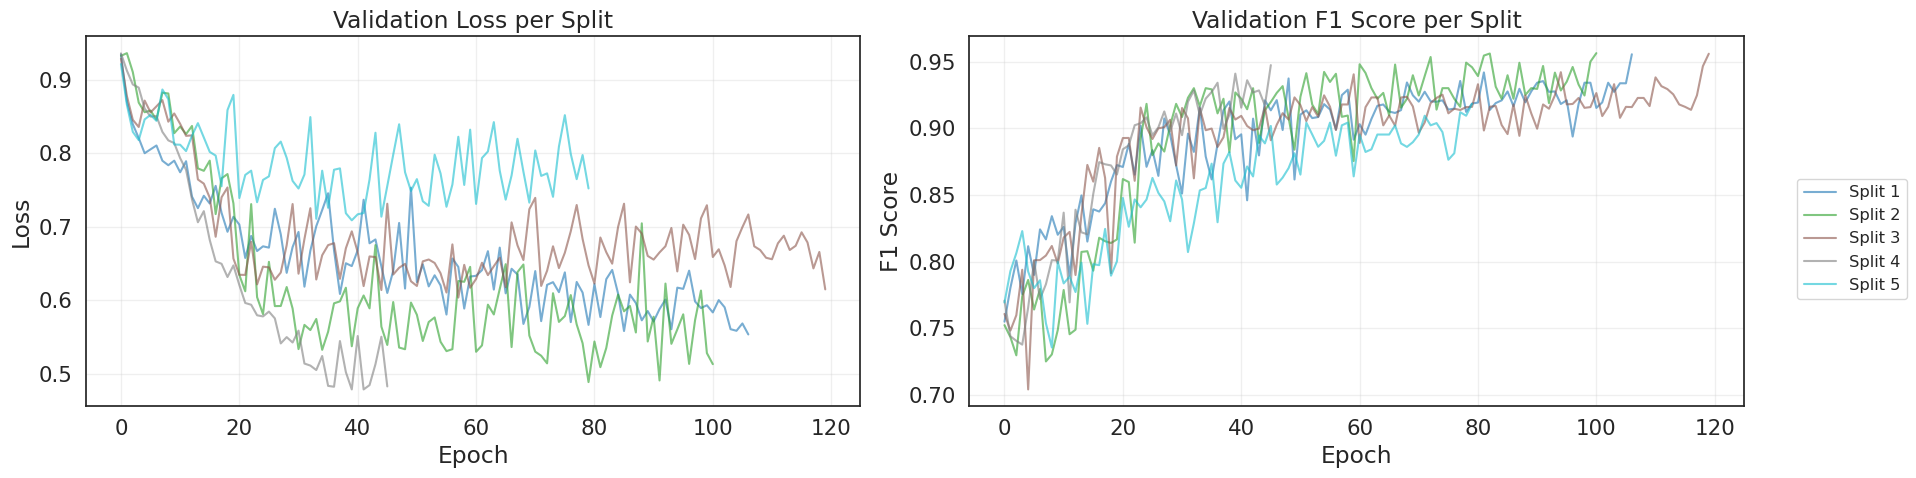

In [172]:
# @title Plot History
# Create figure with two subplots sharing x axis
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5), sharex=True)

# Color palette for K splits
colors = plt.cm.get_cmap('tab10', K)

# Plot validation loss for each split
for split in range(K):
    axes[0].plot(losses[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[0].set_title('Validation Loss per Split')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].grid(alpha=0.3)

# Plot validation F1 score for each split
for split in range(K):
    axes[1].plot(metrics[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[1].set_title('Validation F1 Score per Split')
axes[1].set_ylabel('F1 Score')
axes[1].set_xlabel('Epoch')
axes[1].grid(alpha=0.3)

# Add shared legend on the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(right=0.975)
plt.show()

In [179]:
def ensemble_predict_and_collect_probs(model_paths, dataloader, device):
    """
    load each model sequentially, does inference and collect the mean probabilitye
    of every window of each user for all the k models

    Return: a dictionary mapping sample_index to a list of probability arrays (one for each model).
    """
    all_models_probs = {} # { user_id: [prob_model1_array, prob_model2_array, ...] }

    # sort id
    sample_indices = None

    for i, model_path in enumerate(model_paths):
        print(f"Caricamento e inference per Modello {i+1}/{len(model_paths)}: {model_path}")

        # 1. load the model using the same training parameters
        model = RecurrentClassifierWithEmbeddings(
            num_numerical_features=num_numerical_features,
            num_pain_survey_categories=NUM_PAIN_SURVEY_CATEGORIES,
            num_limb_categories=NUM_LIMB_CATEGORIES,
            embedding_dim=EMBEDDING_DIM,
            hidden_size=HIDDEN_SIZE,
            num_layers=HIDDEN_LAYERS,
            num_classes=num_classes,
            dropout_rate=DROPOUT_RATE,
            bidirectional=BIDIRECTIONAL,
            rnn_type=RNN_TYPE
            ).to(device)

        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()

        user_probs_single_model = {} # { user_id: [prob_finestra1, prob_finestra2, ...] }

        with torch.no_grad():
            for x_ps, x_l, x_num, sample_idx in dataloader:
                x_ps, x_l, x_num = x_ps.to(device), x_l.to(device), x_num.to(device)

                with torch.amp.autocast(device_type=device.type, enabled=(device.type == "cuda")):
                    logits = model(x_ps, x_l, x_num)

                # compute softmax probabilities
                probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()

                # Aggregate probabilities window by window for each pirate
                for j, user_id in enumerate(sample_idx.cpu().numpy()):
                    if user_id not in user_probs_single_model:
                        user_probs_single_model[user_id] = []
                    user_probs_single_model[user_id].append(probs[j])

        # 2. soft aggregation: compute probabilities mean for the windows for each model
        for user_id, probs_list in user_probs_single_model.items():
            # Mean of Softmaxes across all windows for this user/model
            mean_prob = np.mean(probs_list, axis=0)

            if user_id not in all_models_probs:
                all_models_probs[user_id] = []

            all_models_probs[user_id].append(mean_prob)

        # save pirates id
        if sample_indices is None:
             sample_indices = sorted(all_models_probs.keys())

    return all_models_probs, sample_indices

In [190]:
#here we retrieve all the paths of the k-fold models (test 3 was the submission one)
model_paths = ['models/gru_mono_test_5_removed_joint10/split_0_model.pt', 'models/gru_mono_test_5_removed_joint10/split_1_model.pt',
               'models/gru_mono_test_5_removed_joint10/split_2_model.pt', 'models/gru_mono_test_5_removed_joint10/split_3_model.pt',
               ]

In [182]:
# normalizing test set using robust scaler (this cell must be runned both in case of ensamble and single model)
joint_columns = [col for col in X_test.columns if col.startswith('joint_')]

# 1 Compute Robust Scaling statistics on training set (Median, Q1, Q3)
test_median = X_test[joint_columns].median()
test_q3 = X_test[joint_columns].quantile(0.75)
test_q1 = X_test[joint_columns].quantile(0.25)
test_iqr = test_q3 - test_q1

# 2 Apply Robust Scaling to the test set, with a stability check to deal with constant features
for col in joint_columns:
    iqr = test_iqr[col]
    median = test_median[col]

    # stability check: if IQR goes to 0 (constant feature), set to 0
    if iqr < 1e-4:
       X_test.loc[:, col] = 0.0
    else:
    # Robust Scaling: (X - Median) / IQR
       X_test.loc[:, col] = (X_test[col] - median) / iqr

In [183]:
#check to control normalization
print(X_test['joint_30'].head())
print(X_test['joint_30'].max())
print(X_test['joint_30'].min())

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: joint_30, dtype: float32
0.0
0.0


In [191]:
#creation of the sequence on test set (this cell must be runned both in case of ensamble and single model)
print("starting to create test sequence...")

X_test_sur, X_test_limb, X_test_num, _, sample_index_test_seq = build_sequences_with_embeddings(
    X_test, # normalized above
    window=WINDOW_SIZE,
    stride=STRIDE
)

test_ds = TensorDataset(
    torch.from_numpy(X_test_sur).float(),
    torch.from_numpy(X_test_limb).long(),
    torch.from_numpy(X_test_num).float(),
    torch.from_numpy(sample_index_test_seq).long()
)

test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print("test sequence created successfully!")

starting to create test sequence...
test sequence created successfully!


In [192]:
#ensembling of the k-models
all_probs_by_user, sorted_indices = ensemble_predict_and_collect_probs(
    model_paths=model_paths,
    dataloader=test_loader,
    device=device,
    # ...
)
final_labels = []

# final aggregation using softmax avg
for user_id in sorted_indices:
    # probs_per_model is a list of 5 probabilities array, one for each model
    probs_per_model = all_probs_by_user[user_id]

    # compute mean on all five models
    final_mean_prob = np.mean(probs_per_model, axis=0)

    # take the class with the highest mean
    predicted_class = np.argmax(final_mean_prob)
    final_labels.append(predicted_class)

reversed_map = {
    0: 'no_pain',
    1: 'low_pain',
    2: 'high_pain'
}
# mapping, data frame creation and saving
predicted_labels_textual = np.vectorize(reversed_map.get)(np.array(final_labels))

results_df = pd.DataFrame({
    'sample_index': sorted_indices,
    'label': predicted_labels_textual
})

OUTPUT_FILE_PATH = 'submission_ensemble_noJoint10_4mod_k5.csv'
results_df.to_csv(OUTPUT_FILE_PATH, index=False)

print(f"\n Ensembling done! Results saved at: **{OUTPUT_FILE_PATH}**")
print("\n submission file:")
# print to check output
print(results_df.head())

Caricamento e inference per Modello 1/4: models/gru_mono_test_5_removed_joint10/split_0_model.pt
Caricamento e inference per Modello 2/4: models/gru_mono_test_5_removed_joint10/split_1_model.pt
Caricamento e inference per Modello 3/4: models/gru_mono_test_5_removed_joint10/split_2_model.pt
Caricamento e inference per Modello 4/4: models/gru_mono_test_5_removed_joint10/split_3_model.pt

 Ensembling done! Results saved at: **submission_ensemble_noJoint10_4mod_k5.csv**

 submission file:
   sample_index    label
0             0  no_pain
1             1  no_pain
2             2  no_pain
3             3  no_pain
4             4  no_pain


In [186]:
FINAL_MODEL_PATH = 'models/gru_mono_test_5_removed_joint10/split_1_model.pt'

try:
    best_model = RecurrentClassifierWithEmbeddings(
            num_numerical_features=num_numerical_features,
            num_pain_survey_categories=NUM_PAIN_SURVEY_CATEGORIES,
            num_limb_categories=NUM_LIMB_CATEGORIES,
            embedding_dim=EMBEDDING_DIM,
            hidden_size=HIDDEN_SIZE,
            num_layers=HIDDEN_LAYERS,
            num_classes=num_classes,
            dropout_rate=DROPOUT_RATE,
            bidirectional=BIDIRECTIONAL,
            rnn_type=RNN_TYPE
    ).to(device)

    best_model.load_state_dict(torch.load(FINAL_MODEL_PATH, map_location=device))
    best_model.eval()

    print('best_model loaded correctly!')
except NameError:
    print("\n ERRORE CRITICO: La classe 'RecurrentClassifierWithEmbeddings' non è definita.")
    print("Devi includere o importare la definizione della classe del modello!")
except FileNotFoundError:
    print(f"\n ERRORE: Pesi del modello non trovati al percorso: {FINAL_MODEL_PATH}")
    print("Controlla il percorso e aggiorna FINAL_MODEL_PATH.")
except Exception as e:
    print(f"\n ERRORE durante il caricamento: {e}")

best_model caricato correttamente!


In [188]:
def predict_and_aggregate_emb(model, test_loader, device):
    """
    Esegue l'inference sul set di test, aggrega le probabilità per utente
    (media del Softmax) e determina la classe predetta a livello utente.
    """
    model.eval() # put model in eval mode

    # Containers to cumulate probabilities and user_index
    user_probs = defaultdict(list)
    user_indices = []

    with torch.no_grad(): # don't compute gradients
        # test_loader returns: X_ps, X_l, X_num, sample_idx
        for x_ps, x_l, x_num, sample_idx in test_loader:

            # 1. move data on device (CPU/GPU)
            x_ps, x_l, x_num = (
                x_ps.to(device),
                x_l.to(device),
                x_num.to(device),
            )

            # 2. Forward pass
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == "cuda")):
                logits = model(x_ps, x_l, x_num)

            # 3. Compute softmax probabilities
            probs = F.softmax(logits, dim=1).cpu().numpy()

            # 4. Aggregate the probabilities window by window for each user
            for i, user_id in enumerate(sample_idx.cpu().numpy()):
                user_probs[user_id].append(probs[i])

    # 5. final aggregation at pirate level
    final_predictions = []

    # Sort pirates id
    sorted_user_ids = sorted(user_probs.keys())

    for user_id in sorted_user_ids:
        probs_list = user_probs[user_id]

        # Compute the mean of each window probability for each user
        mean_prob = np.mean(probs_list, axis=0)

        # choose the prediction label using mean argmax
        pred_class = np.argmax(mean_prob)

        final_predictions.append(pred_class)
        user_indices.append(user_id) # use ordered pirate id

    # return user and prediction
    return np.array(user_indices), np.array(final_predictions)

In [189]:
# 1. inference execution
print("\nInizio fase di inference...")
# execute final prediction using loaded model and the new test data loader
sample_indices_final, predicted_labels = predict_and_aggregate_emb(
    model=best_model,
    test_loader=test_loader,
    device=device
)

print(f"✅ Inference completata per {len(sample_indices_final)} utenti unici.")

# 2. create output dataframe
OUTPUT_FILE_PATH = 'submission_gru5_split1.csv'

results_df = pd.DataFrame({
    'sample_index': sample_indices_final,
    'label': predicted_labels
})

reversed_map = {
    0: 'no_pain',
    1: 'low_pain',
    2: 'high_pain'
}
results_df['label'] = results_df['label'].map(reversed_map)

# 3. save file csv
results_df.to_csv(OUTPUT_FILE_PATH, index=False)

print(f"\n operation completed! Results saved at: *{OUTPUT_FILE_PATH}*")
print("\n submit file is:")
print(results_df.head())


Inizio fase di inference...
✅ Inference completata per 1324 utenti unici.

✨ Operazione completata! Risultati salvati in: *submission_gru5_split1.csv*

Anteprima del file di submission (le colonne richieste):
   sample_index    label
0             0  no_pain
1             1  no_pain
2             2  no_pain
3             3  no_pain
4             4  no_pain


In [ ]:
# Funzione per plot delle learning curves
def plot_history(history: dict, title: str = 'Learning Curves'):
    """
    Plot delle learning curves per loss, accuracy e F1 score.
    
    Args:
        history: Dictionary con chiavi 'train_loss', 'valid_loss', 'train_accuracy', 
                'valid_accuracy', 'train_f1', 'valid_f1'
        title: Titolo del grafico
    """
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    
    axs[0].plot(epochs, history['train_loss'], label='Train')
    axs[0].plot(epochs, history['valid_loss'], label='Valid')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend()
    
    axs[1].plot(epochs, history['train_accuracy'], label='Train')
    axs[1].plot(epochs, history['valid_accuracy'], label='Valid')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].legend()
    
    axs[2].plot(epochs, history['train_f1'], label='Train F1')
    axs[2].plot(epochs, history['valid_f1'], label='Valid F1')
    axs[2].set_title('Macro F1')
    axs[2].set_xlabel('Epoch')
    axs[2].legend()
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


In [ ]:
# Ottenere predizioni di validazione per il miglior split (split_1)
# Ricreiamo il validation set per split_1 per ottenere le predizioni

# Preparazione dei dati per split_1 (stesso seed e split della cross-validation)
user_df = X_train_labeled.drop_duplicates(subset=["sample_index"])[["sample_index","label"]]
X_users = user_df["sample_index"].values
y_users = user_df["label"].values

skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=SEED)
train_idx, val_idx = list(skf.split(X_users, y_users))[1]  # split_1 è l'indice 1
train_users = X_users[train_idx]
val_users = X_users[val_idx]

df_val_split1 = X_train_labeled[X_train_labeled['sample_index'].isin(val_users)].copy()

# Normalizzazione (usando le statistiche del training set)
df_train_split1 = X_train_labeled[X_train_labeled['sample_index'].isin(train_users)].copy()
joint_columns = [col for col in df_train_split1.columns if col.startswith('joint_')]

train_median = df_train_split1[joint_columns].median()
train_q3 = df_train_split1[joint_columns].quantile(0.75)
train_q1 = df_train_split1[joint_columns].quantile(0.25)
train_iqr = train_q3 - train_q1

for col in joint_columns:
    iqr = train_iqr[col]
    median = train_median[col]
    if iqr < 1e-4:
        df_val_split1.loc[:, col] = 0.0
    else:
        df_val_split1.loc[:, col] = (df_val_split1[col] - median) / iqr

# Creazione delle sequenze per validation
X_val_sur, X_val_limb, X_val_num, y_val_seq, sample_index_val = build_sequences_with_embeddings(
    df_val_split1, window=WINDOW_SIZE, stride=STRIDE
)

val_ds_split1 = TensorDataset(
    torch.from_numpy(X_val_sur).float(),
    torch.from_numpy(X_val_limb).long(),
    torch.from_numpy(X_val_num).float(),
    torch.from_numpy(y_val_seq).long(),
    torch.from_numpy(sample_index_val).long()
)

val_loader_split1 = make_loader(val_ds_split1, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# Ottenere predizioni
best_model.eval()
user_probs = defaultdict(list)
user_targets = {}

with torch.no_grad():
    for x_ps, x_l, x_num, targets, sample_idx in val_loader_split1:
        x_ps, x_l, x_num, targets = (
            x_ps.to(device),
            x_l.to(device),
            x_num.to(device),
            targets.to(device),
        )
        
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == "cuda")):
            logits = best_model(x_ps, x_l, x_num)
        
        probs = F.softmax(logits, dim=1).cpu().numpy()
        
        for i, user_id in enumerate(sample_idx.cpu().numpy()):
            user_probs[user_id].append(probs[i])
            user_targets[user_id] = targets[i].cpu().item()

# Aggregazione delle predizioni per utente
all_user_preds = []
all_user_targets = []

for user_id, probs_list in user_probs.items():
    mean_prob = np.mean(probs_list, axis=0)
    pred_class = np.argmax(mean_prob)
    all_user_preds.append(pred_class)
    all_user_targets.append(user_targets[user_id])

best_preds = np.array(all_user_preds)
best_targets = np.array(all_user_targets)

print(f"Predizioni di validazione ottenute per {len(best_targets)} utenti.")


In [ ]:
# Confusion Matrix per il miglior split
from sklearn.metrics import classification_report, confusion_matrix

IDX2LABEL = {0: 'no_pain', 1: 'low_pain', 2: 'high_pain'}
NUM_CLASSES = 3

# Calcolo F1 score (usando weighted come nella funzione di validazione)
# Questo è il valore che viene salvato durante il training (val_f1)
weighted_f1 = f1_score(best_targets, best_preds, average='weighted')
macro_f1 = f1_score(best_targets, best_preds, average='macro')

print("="*70)
print(f"VALIDATION F1 SCORE (Weighted) - Questo è il valore salvato durante il training")
print(f"  Valore calcolato: {weighted_f1:.4f}")
print(f"  Valore salvato all'epoca 61: 0.9549")
print(f"  Differenza: {abs(weighted_f1 - 0.9549):.4f}")
print("="*70)
print(f"\n⚠️  IMPORTANTE PER KAGGLE:")
print(f"  Macro F1 (metrica principale su Kaggle): {macro_f1:.4f}")
print(f"  Questo è il punteggio che probabilmente vedrai su Kaggle!")
print(f"  (Il weighted F1 è più alto perché pesa le classi maggioritarie)")
print("="*70)
print("\nClassification Report:")
print(classification_report(
    best_targets,
    best_preds,
    target_names=[IDX2LABEL[i] for i in range(NUM_CLASSES)],
))

cf = confusion_matrix(best_targets, best_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cf,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[IDX2LABEL[i] for i in range(NUM_CLASSES)],
    yticklabels=[IDX2LABEL[i] for i in range(NUM_CLASSES)],
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix — Split 1 (Best Model)\nWeighted F1: {weighted_f1:.4f} (training) | Macro F1: {macro_f1:.4f} (Kaggle)')
plt.tight_layout()
plt.show()


In [ ]:
# Learning Curves per il miglior split
# Nota: Per avere le metriche di training, sarebbe necessario salvare l'history durante il training
# Qui usiamo le metriche di validazione disponibili dai risultati della cross-validation

# Ricostruiamo un history parziale usando le metriche di validazione disponibili
# (solo validazione, non abbiamo i dati di training salvati)
if 'metrics' in locals() and 'split_1' in metrics:
    # Usiamo solo le metriche di validazione disponibili
    valid_f1 = metrics['split_1']
    valid_loss = losses['split_1'] if 'losses' in locals() and 'split_1' in losses else [0] * len(valid_f1)
    
    # Per le learning curves complete, sarebbe necessario salvare l'history durante il training
    # Qui creiamo un history minimale solo con validazione per mostrare la struttura
    print("Nota: Le metriche di training non sono state salvate durante la cross-validation.")
    print("Per visualizzare le learning curves complete, è necessario salvare l'history durante il training.")
    print(f"Metriche di validazione disponibili per {len(valid_f1)} epoche.")
    
    # Se vuoi visualizzare solo le metriche di validazione:
    epochs = range(1, len(valid_f1) + 1)
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    
    axs[0].plot(epochs, valid_loss, label='Valid Loss', color='orange')
    axs[0].set_title('Validation Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend()
    
    axs[1].plot(epochs, valid_f1, label='Valid F1', color='orange')
    axs[1].set_title('Validation F1 Score')
    axs[1].set_xlabel('Epoch')
    axs[1].legend()
    
    axs[2].plot(epochs, valid_f1, label='Valid F1', color='orange')
    axs[2].set_title('Validation Macro F1')
    axs[2].set_xlabel('Epoch')
    axs[2].legend()
    
    plt.suptitle('Learning Curves — Split 1 (Validation Only)')
    plt.tight_layout()
    plt.show()
else:
    print("Metriche di validazione non disponibili. Eseguire prima la cross-validation.")


In [ ]:
# Tabella riassuntiva con performance per classe
from sklearn.metrics import f1_score, recall_score

# Calcolo delle metriche per classe
f1_per_class = f1_score(best_targets, best_preds, average=None)
recall_per_class = recall_score(best_targets, best_preds, average=None)

# Support (numero di esempi per classe nel validation set)
support = np.bincount(best_targets, minlength=NUM_CLASSES)

# Conteggi originali (dal training set completo)
original_counts = y_train['label'].value_counts().sort_index().values

# Conteggi dopo oversampling (se non c'è oversampling, sono uguali agli originali)
# Nota: nel tuo caso non sembra esserci oversampling, quindi usiamo gli originali
oversampled_counts = original_counts.copy()

# Class weights (già calcolati in precedenza)
class_weights_array = class_weights.cpu().numpy() if hasattr(class_weights, 'cpu') else class_weights

# Creazione della figura con la tabella
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Grafico: Tabella riassuntiva con performance
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis('off')

summary_data = []
for i in range(NUM_CLASSES):
    label = IDX2LABEL[i]
    summary_data.append([
        label,
        f"{original_counts[i]}",
        f"{oversampled_counts[i]}",
        f"{class_weights_array[i]:.3f}",
        f"{support[i]}",
        f"{f1_per_class[i]:.3f}",
        f"{recall_per_class[i]:.3f}"
    ])

table = ax9.table(cellText=summary_data,
                 colLabels=['Classe', 'Orig', 'Dopo OS', 'Peso', 'Support', 'F1', 'Recall'],
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2.5)

# Colora le celle in base alle performance F1
for i in range(1, len(summary_data) + 1):
    f1_val = float(summary_data[i-1][5])
    if f1_val >= 0.95:
        table[(i, 5)].set_facecolor('#90EE90')  # Verde chiaro
    elif f1_val >= 0.85:
        table[(i, 5)].set_facecolor('#FFE4B5')  # Giallo chiaro
    else:
        table[(i, 5)].set_facecolor('#FFB6C1')  # Rosa chiaro

ax9.set_title('Riepilogo: Bilanciamento e Performance', fontsize=14, fontweight='bold', pad=20)

# Calcolo delle metriche complessive
weighted_f1_summary = f1_score(best_targets, best_preds, average='weighted')
macro_f1_summary = f1_score(best_targets, best_preds, average='macro')
accuracy = accuracy_score(best_targets, best_preds)

plt.suptitle('Correlazione tra Tecniche di Bilanciamento e Performance del Modello\n'
             f'Weighted F1: {weighted_f1_summary:.3f} | Macro F1: {macro_f1_summary:.3f} | '
             f'Accuracy: {accuracy:.3f}',
             fontsize=16, fontweight='bold', y=0.995)

plt.show()


## Note sulle Learning Curves

Per visualizzare le learning curves complete con metriche di training e validazione, è necessario modificare la funzione `fit_emb` per salvare anche le metriche di training durante l'addestramento. 

Attualmente, la funzione `fit_emb` restituisce solo `train_loss`, `val_loss`, `train_f1`, `val_f1`. Per usare la funzione `plot_history` completa, sarebbe necessario aggiungere anche `train_accuracy` e `valid_accuracy` modificando le funzioni `train_one_epoch_emb` e `validate_one_epoch_emb` per calcolare e restituire anche l'accuracy.

La funzione `plot_history` è già definita e pronta all'uso. Una volta che avrai l'history completa con tutte le metriche, potrai chiamarla così:

```python
plot_history(best_history, title=f"Learning Curves — Split 1")
```
